# FINAL PROJECT - Prashant Khorana



## Executive summary

As part of this final project, I investigated several parameters from the cook country assessors authority (CCAO) dataset. The objective at this stage was not to provide a final valuation model, but to understand the sample data and build a model that predicts sales price as accurately as possible. 

I visually inspected all the features and considered all columns. Although features such as property classes, PIN need to be better understood, my model is good enough at this stage, and I don't see much of a rationale to further engineer features (i.e. don't want to overengineer). 

A key transformation I applied was the log-normal transformation on the building squre feet and the sales price to make the model features less skewed (although that didn't exactly remove the skew). 

Using just four features, I was able to develop a model (OLS) with an r-squared of 99.8%. However, further improvements could be made to remove skewness from the final model and improve the 'Omnibus' factor. 

### Importing Libraries

In [ ]:
# Importing required Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
sns.set(style="ticks", palette="ocean")

import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,12)
%config InlineBackend.figure_format = 'retina'


### Introduction 

The CCAO has requested us to analyze a dataset and conduct an exploratory analysis of the sample data provided. The provided dataset consists of a random sample of homes that have sold in the three regions of Cook County (Northern Townships, City of Chicago, Southwest Townships) during tax years 2003-2018. <br>
Our objective is to gain an understanding of the data, comment on key metrics and how useful they are, and build some models that can predict the sales price of the properties using the features. This model will likely be used to make asssessment of taxes that need to be paid by the property owner.

#### Reading the data frame

In [2]:
df=pd.read_csv("dataset_final_project.csv")

Lets investigate the first few rows of the data, the shape of the data set i.e. rows and columns, and investigate the column names

In [3]:
df.head()

PIN                Property_Address  Tax_Year  Property_Class  \
0   8124170000000  613 S SCHOOL ST MOUNT PROSPECT      2018             203   
1  13113220261025           7101 N CICERO STE 100      2003             299   
2   6352050000000        602  MAPLE DR STREAMWOOD      2018             278   
3  27174070330000                   10626 DANI LN      2014             295   
4  14312140120000            1507 SUNSET RIDGE RD      2003             211   

   Census_Tract Type_of_Residence  Rooms  Bedrooms          Basement  \
0      804901.0               1.0    6.0       4.0               1.0   
1      140301.0               NaN    NaN       NaN               NaN   
2      804509.0               2.0    8.0       4.0               3.0   
3      824114.0           2-story    5.0       3.0  Partial basement   
4      832300.0           3-story   18.0       6.0     Full basement   

   Fireplaces  ... Full_Baths  Half_Baths  Building_Square_Feet  \
0         1.0  ...        1.0         1.0                1461.0   
1         NaN  ...        NaN         NaN                   NaN   
2         0.0  ...        2.0         1.0                2224.0   
3         1.0  ...        2.0         1.0                1817.0   
4         0.0  ...        6.0         0.0                4604.0   

   Land_Square_Feet    Age  Longitude   Latitude  Walkscore        Walkfac  \
0            8712.0   60.0 -87.930691  42.054184       49.0  Car-Dependent   
1               NaN    NaN -87.747614  42.010341       48.0  Car-Dependent   
2            8316.0   19.0 -88.168322  42.002096       15.0  Car-Dependent   
3            1399.0    7.0 -87.878278  41.604719       29.0  Car-Dependent   
4            3000.0  122.0 -87.789610  42.124919       11.0  Car-Dependent   

  Sale_Price  
0     298000  
1     171000  
2     255000  
3     254900  
4     715000  

[5 rows x 21 columns]

In [4]:
df.shape

(20000, 21)

There's 20K rows, a fairly large number of sample points. This should be sufficient for building an OLS based model.

In [5]:
df.columns

Index(['PIN', 'Property_Address', 'Tax_Year', 'Property_Class', 'Census_Tract',
       'Type_of_Residence', 'Rooms', 'Bedrooms', 'Basement', 'Fireplaces',
       'Central_Air', 'Full_Baths', 'Half_Baths', 'Building_Square_Feet',
       'Land_Square_Feet', 'Age', 'Longitude', 'Latitude', 'Walkscore',
       'Walkfac', 'Sale_Price'],
      dtype='object')

### Data description

Our data is from the cook county assessors authority, so I'm not concerned about the authenticty of the data or survey bias at this stage. However, there could be features exogenous to the list provided that could influence the price. Furthermore, some features that are important such as 'race' or 'gender' of owner (if used, could have ethical consequences). 

Lets discuss the 21 columns we have briefly. 

<br> PIN - not really relevant, as it is mostly useful for machine reading purposees and unique identification. Probably needs to be broken down further to blocks perhaps to extract any real value <br>
<br> Property Address - not really useful as is; need to think about if some value can be extracted from the postal code <br>
<br> Tax Year - somewhat intresting - just to eyeball - the evolution of taxes over the years <br>
<br> Property Class - interesting - as we can observe if there's any clear relationship between a type of property and taxes paid (or otherwise)<br>
<br> Cenus_trac - maybe useful; don't know <br>
<br> Type of residence - useful (seemingly so for now) <br>
<br> Rooms/bedrooms - useful as larger # of rooms are likely to add to the price  <br>
<br> Basement - maybe useful; will explore in this exercise <br>
<br> Fireplaces - seemingly useful from a personal perspective <br>
<br> Central_Air - useful (considering of hot summer days and global warming) <br>
<br> Full_Baths/Half_Baths - useful <br>
<br> Building_Sq_Feet/Land_Sq_Feet - useful as a comparability measure <br>
<br> Age - useful for vintage profiling <br>
<br> Long/Lat - useful - but geotagging related analysis is beyond scope of this project <br>
<br> Walkscore/walkfrac - seemingly useful factor of 'walkability' <br>
<br> Sale_Price - What we're trying to solve as Y variable i.e. we're trying to fit all above to sales price <br>

In [6]:
df.dtypes

PIN                       int64
Property_Address         object
Tax_Year                  int64
Property_Class            int64
Census_Tract            float64
Type_of_Residence        object
Rooms                   float64
Bedrooms                float64
Basement                 object
Fireplaces              float64
Central_Air              object
Full_Baths              float64
Half_Baths              float64
Building_Square_Feet    float64
Land_Square_Feet        float64
Age                     float64
Longitude               float64
Latitude                float64
Walkscore               float64
Walkfac                  object
Sale_Price                int64
dtype: object

Note that some of the object variables such as Central_Air and Type_of_Residence need to considered for our model, which tells us that we have some categorical variables in the mix of final factors of consideration

### Cleaning the data

We'll drop NAs to start with as NAs distort the values

In [7]:
clean_df=df.dropna()

In [8]:
clean_df.head()

PIN                Property_Address  Tax_Year  Property_Class  \
0   8124170000000  613 S SCHOOL ST MOUNT PROSPECT      2018             203   
2   6352050000000        602  MAPLE DR STREAMWOOD      2018             278   
3  27174070330000                   10626 DANI LN      2014             295   
4  14312140120000            1507 SUNSET RIDGE RD      2003             211   
7   5313050000000      919 E GLENWOOD RD GLENVIEW      2018             204   

   Census_Tract Type_of_Residence  Rooms  Bedrooms          Basement  \
0      804901.0               1.0    6.0       4.0               1.0   
2      804509.0               2.0    8.0       4.0               3.0   
3      824114.0           2-story    5.0       3.0  Partial basement   
4      832300.0           3-story   18.0       6.0     Full basement   
7      801400.0               1.0    7.0       3.0               1.0   

   Fireplaces  ... Full_Baths  Half_Baths  Building_Square_Feet  \
0         1.0  ...        1.0         1.0                1461.0   
2         0.0  ...        2.0         1.0                2224.0   
3         1.0  ...        2.0         1.0                1817.0   
4         0.0  ...        6.0         0.0                4604.0   
7         1.0  ...        1.0         1.0                1957.0   

   Land_Square_Feet    Age  Longitude   Latitude  Walkscore        Walkfac  \
0            8712.0   60.0 -87.930691  42.054184       49.0  Car-Dependent   
2            8316.0   19.0 -88.168322  42.002096       15.0  Car-Dependent   
3            1399.0    7.0 -87.878278  41.604719       29.0  Car-Dependent   
4            3000.0  122.0 -87.789610  42.124919       11.0  Car-Dependent   
7           20500.0   67.0 -87.763116  42.071165       18.0  Car-Dependent   

  Sale_Price  
0     298000  
2     255000  
3     254900  
4     715000  
7     425000  

[5 rows x 21 columns]

In [9]:
clean_df.shape

(14147, 21)

 Notice that we had 20K rows, but now we're down to ~14K rows; we've lost a significant amount of lines, but still have a robust dataset as the sample size is big enough.  

### Exploratory analysis, correlation analysis, and pre-processing

In [10]:
clean_df.describe()

PIN      Tax_Year  Property_Class   Census_Tract  \
count  1.414700e+04  14147.000000    14147.000000   14147.000000   
mean   1.534827e+13   2011.321482      221.142645  681786.519262   
std    7.989962e+12      5.936548       30.627633  245210.357372   
min    1.011000e+12   2003.000000      200.000000   10201.000000   
25%    9.243280e+12   2005.000000      203.000000  681300.000000   
50%    1.429129e+13   2011.000000      205.000000  804809.000000   
75%    2.011312e+13   2018.000000      234.000000  819100.000000   
max    3.331207e+13   2018.000000      297.000000  843900.000000   

              Rooms      Bedrooms    Fireplaces    Full_Baths    Half_Baths  \
count  14147.000000  14147.000000  14147.000000  14147.000000  14147.000000   
mean       6.948470      3.479819      0.368064      1.656182      0.479819   
std        3.071483      1.393391      0.636361      0.875450      0.563323   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        5.000000      3.000000      0.000000      1.000000      0.000000   
50%        6.000000      3.000000      0.000000      1.000000      0.000000   
75%        8.000000      4.000000      1.000000      2.000000      1.000000   
max       80.000000     24.000000      9.000000     10.000000      6.000000   

       Building_Square_Feet  Land_Square_Feet           Age     Longitude  \
count          14147.000000      14147.000000  14147.000000  14147.000000   
mean            1793.971513       7467.394783     59.325581    -87.804055   
std             1020.019559      12136.470888     29.884521      0.153851   
min                0.000000        281.000000      1.000000    -88.249985   
25%             1132.000000       3750.000000     42.000000    -87.866593   
50%             1465.000000       5580.000000     56.000000    -87.774777   
75%             2166.000000       8320.000000     82.000000    -87.698670   
max            12377.000000     450890.000000    163.000000    -87.525559   

           Latitude     Walkscore    Sale_Price  
count  14147.000000  14147.000000  1.414700e+04  
mean      41.882210     55.552838  3.278487e+05  
std        0.168960     22.870673  3.190734e+05  
min       41.470024      0.000000  1.000000e+00  
25%       41.756261     39.000000  1.650000e+05  
50%       41.918373     58.000000  2.470000e+05  
75%       42.023214     74.000000  3.749000e+05  
max       42.156899    100.000000  5.300000e+06

Looking at the descriptive statistics, we notice that there are some zero min values. E.g. Building Sq feet has zero min, which is some sort of outlier or error. Similarly in the sale price. We'll have to remove these outliers before we move on to model building

In [11]:
keep_cols = df.columns[df.nunique() > 1]

Lets try and generate a correlation matrix for all the numeric variables to develop a hypothesis on which columns could add explanatory power

In [12]:
numerical_cols = df[keep_cols].select_dtypes('number').columns

In [13]:
correlation = clean_df.corr()

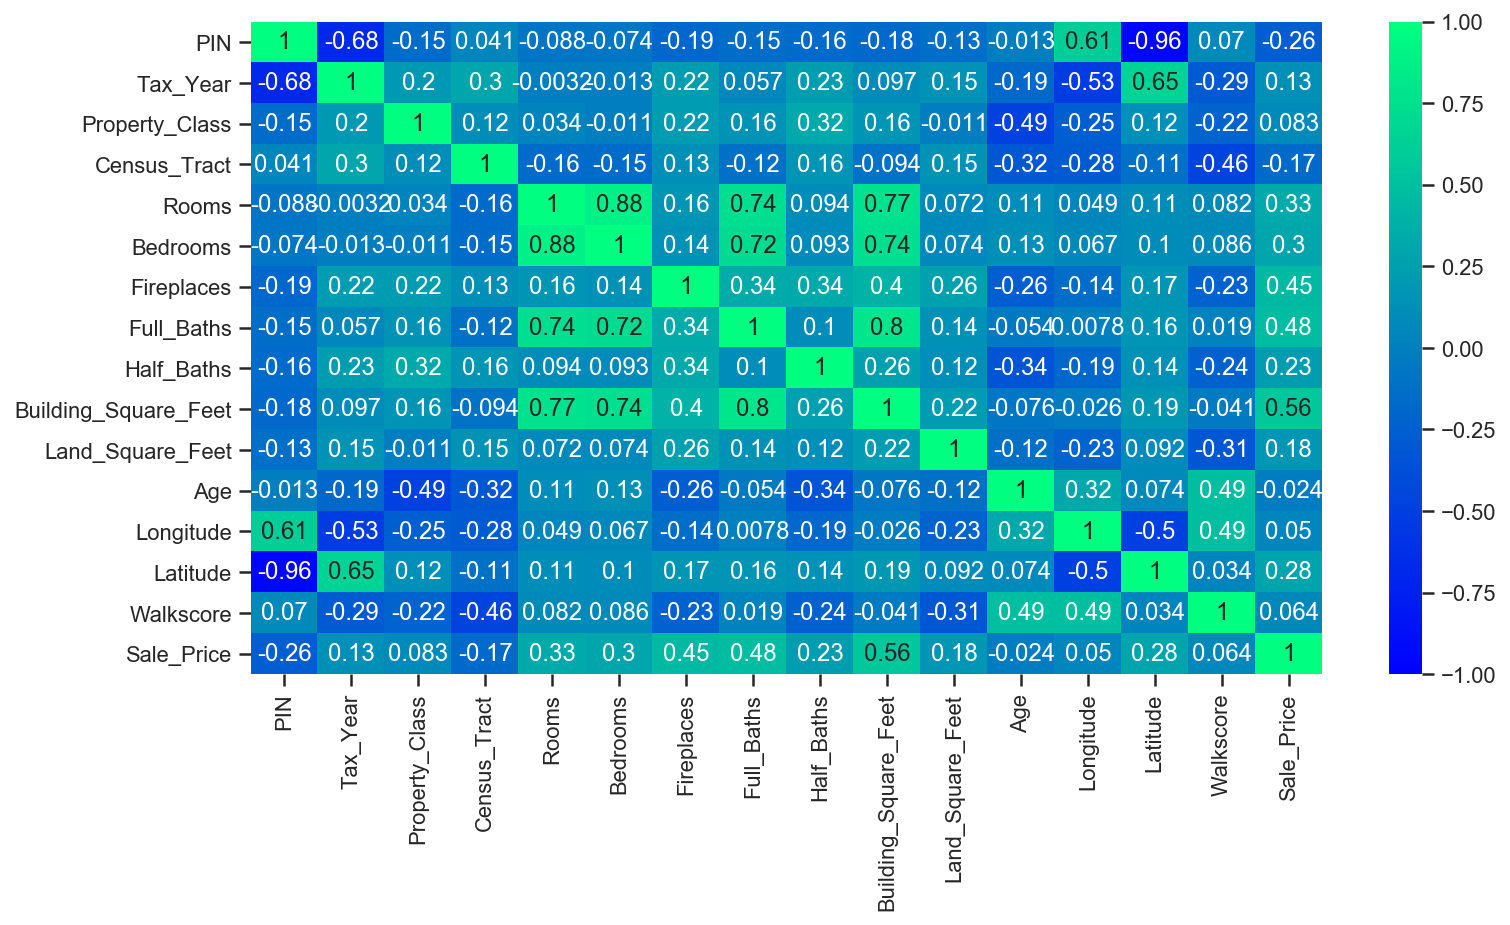

In [14]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, annot = True, cmap  = 'winter', vmax = 1, vmin = -1)

<br>Looking at the above matrix (correlation factor of sale price vs the factors), we notice that several variables have explanatory power (at least we can say so for now. <br> 
<br> Factors such as rooms, bedrooms, fireplaces, full baths, half baths are important. <br>
<br> Building square feet is very useful but land square feet isn't as useful. <br>
<br> Perhaps we can combine full_baths and half_baths to get a better combined factor. <br>
<br> Location is usually important when it comes to real estate, but combining lat and long is not possibly easily. We won't consider geo-encoding for this exercise<br>
<br> Let us combine bathrooms and reconsider the matrix <br>

In [15]:
clean_df["Total_Baths"] = clean_df["Full_Baths"]+ clean_df["Half_Baths"]

/Users/prashant/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
correlation2 = clean_df.corr()

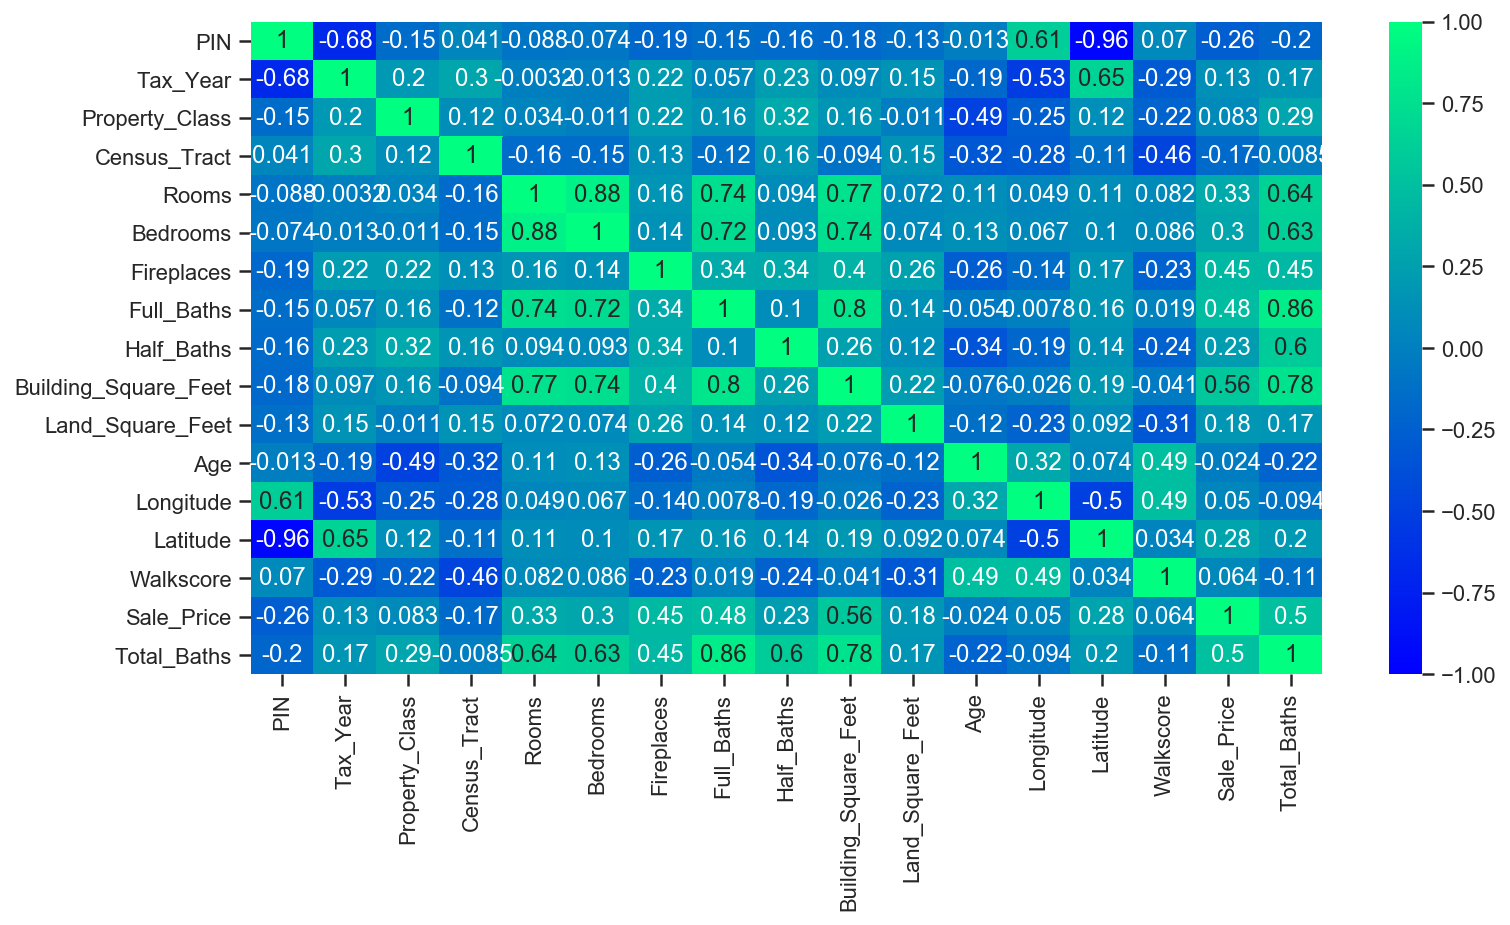

In [17]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation2, annot = True, cmap  = 'winter', vmax = 1, vmin = -1)

Total-baths is correlated to sale price with a factor of 0.5 which is strictly greater than full-baths and half-baths. As such, we'll use Total-baths instead of full-baths and half-baths for our model (but we'll test it seperately).

<br>

Note - the way to read this matrix is - a 1% change in Building Square Feet leads to a 0.56% change in Sales Price (as an example).

#### Let us use the interquartile range method to remove outliers first

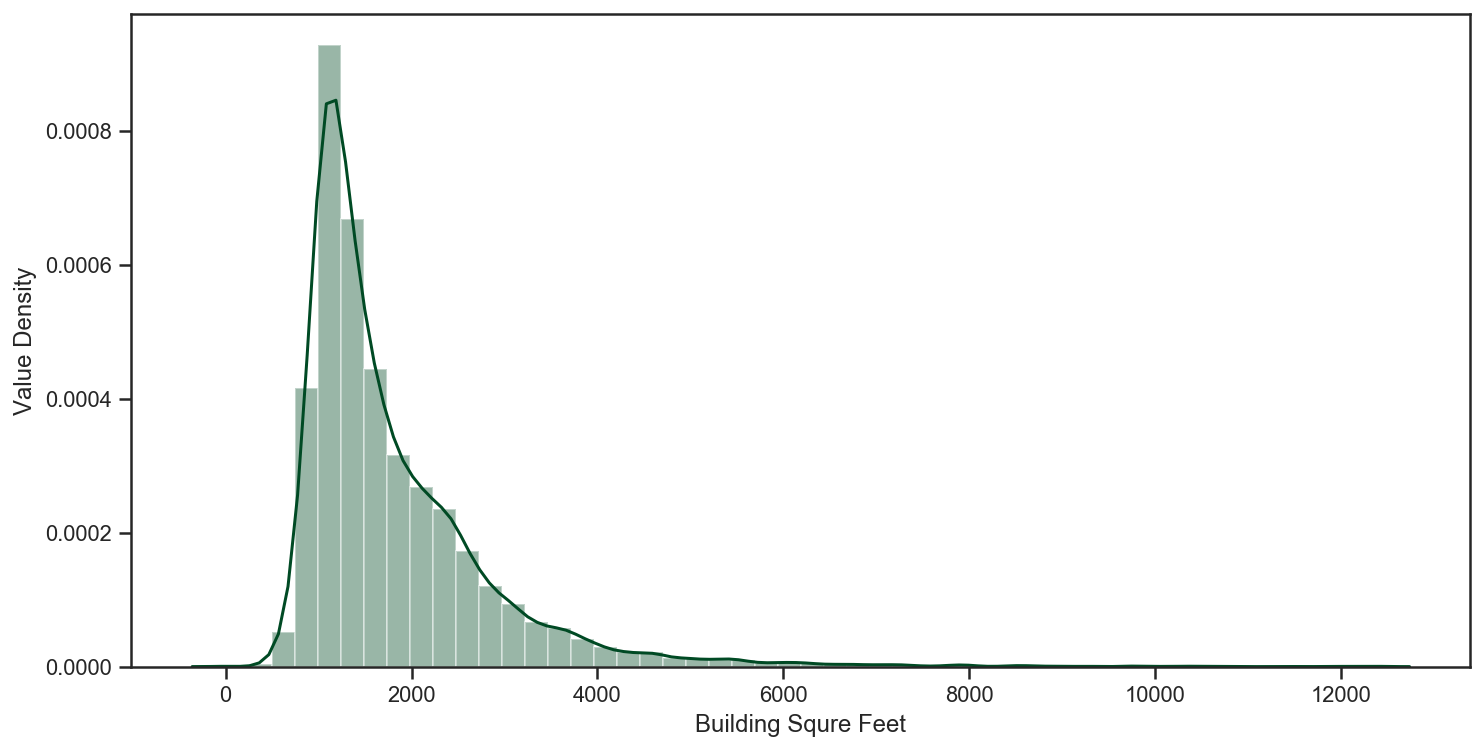

In [100]:
ax = sns.distplot(clean_df["Building_Square_Feet"])
ax.set(ylabel='Value Density', xlabel='Building Squre Feet')
plt.show()

In [19]:
q3_building, q1_building = np.percentile(clean_df["Building_Square_Feet"], [75 ,25])
iqr_building = q3_building-q1_building
# Calculate upper and lower cut-offs
upper_building = q3_building+1.5*iqr_building
lower_building = q1_building-1.5*iqr_building

In [20]:
print(q3_building,q1_building,upper_building,lower_building)

2166.0 1132.0 3717.0 -419.0


Now we can use the bounds we've created to develop a new dataset that is more representative of a 'normal dist.'

In [21]:
clean_df2=clean_df[(clean_df["Building_Square_Feet"] < upper_building) & (clean_df["Building_Square_Feet"] > lower_building)]

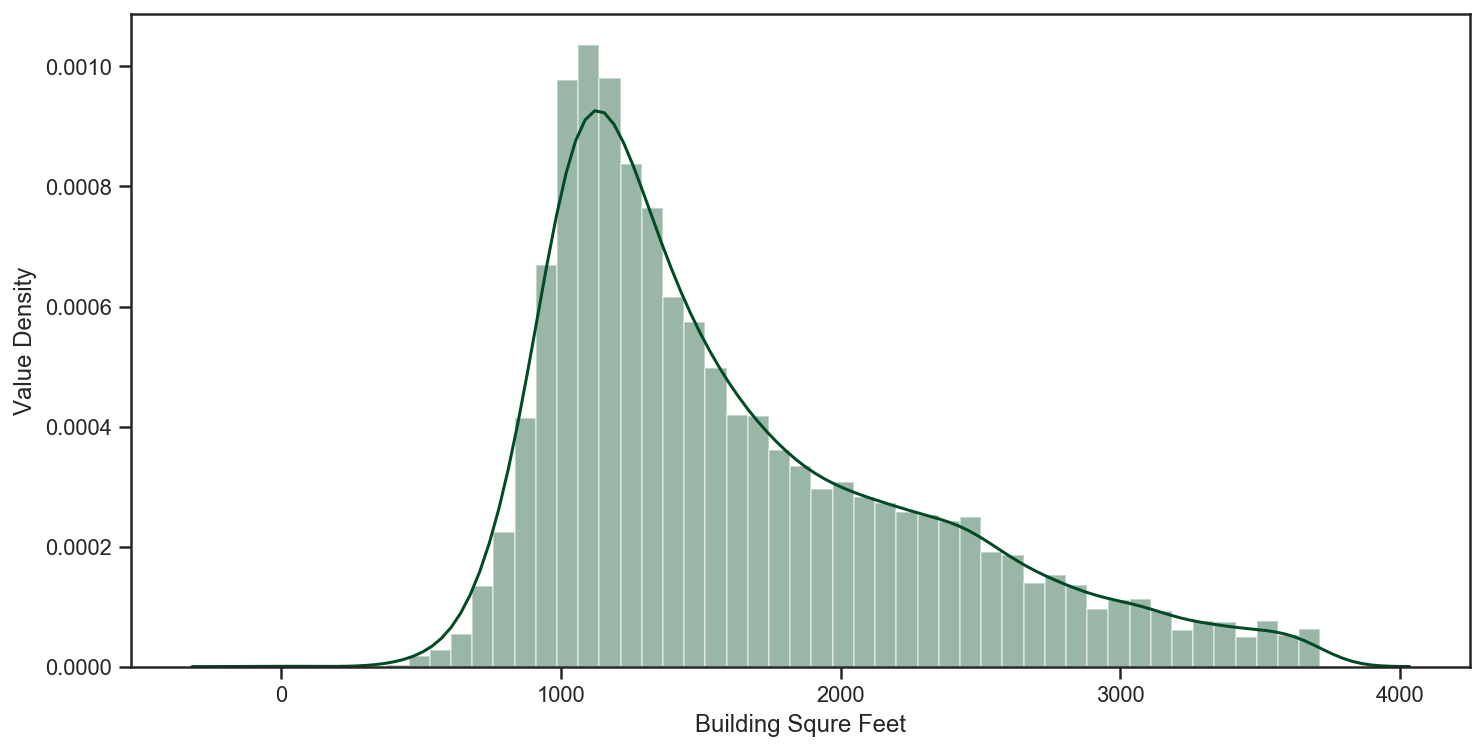

In [101]:
ax2 = sns.distplot(clean_df2["Building_Square_Feet"])
ax2.set(ylabel='Value Density', xlabel='Building Squre Feet')
plt.show()

Seems like the right tail has been trimmed down by our pre-processing efforts

#### Note that the distribution plot also showed us that 'Building squre feet' has a skew; hinting that we should also consider taking a log-normal for our model

Let's try the same process on 'Sale Price'

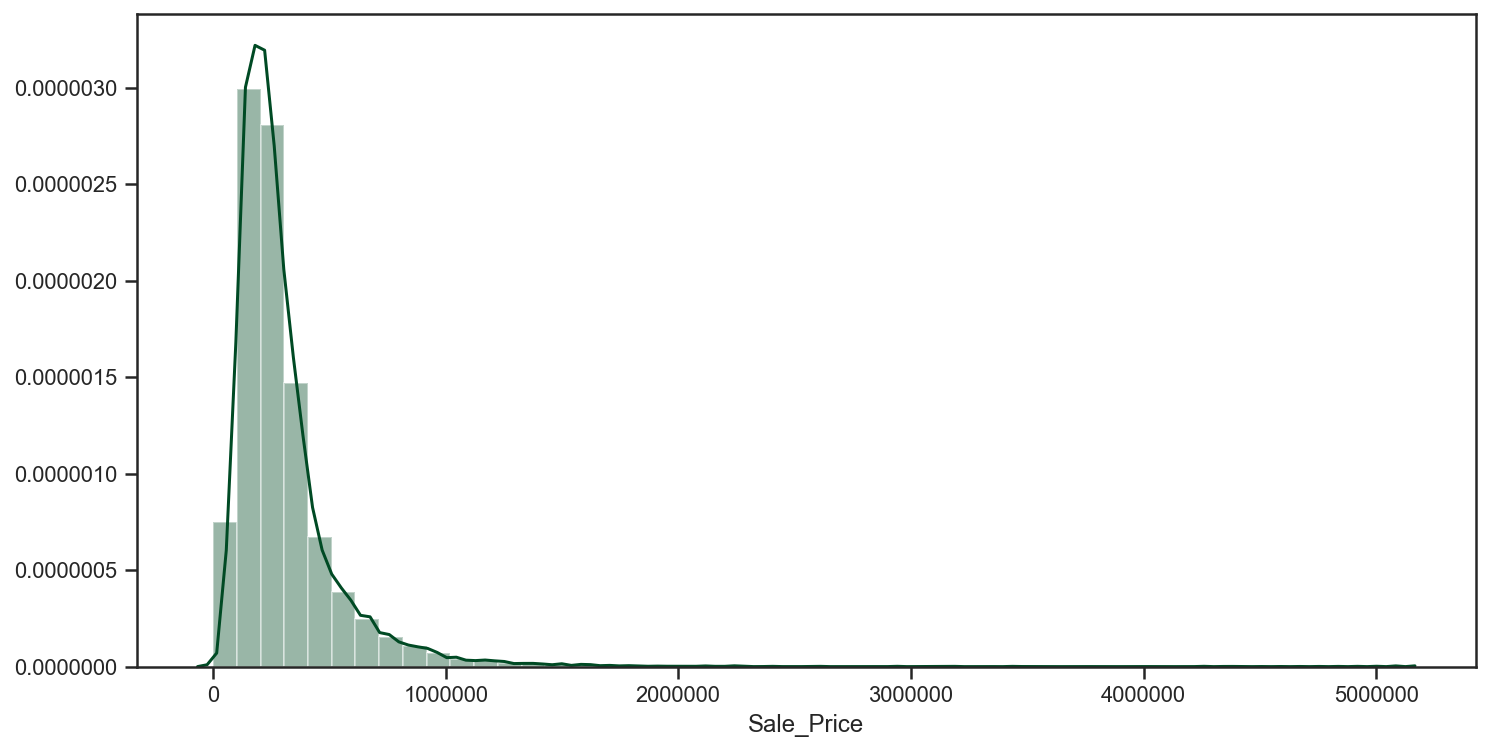

In [23]:
sns.distplot(clean_df2["Sale_Price"])

In [24]:
q3_SalePrice, q1_SalePrice = np.percentile(clean_df2["Sale_Price"], [75 ,25])
iqr_SalePrice = q3_SalePrice-q1_SalePrice
# Calculate upper and lower cut-offs
upper_sale_price = q3_SalePrice+1.5*iqr_SalePrice
lower_sale_price = q1_SalePrice-1.5*iqr_SalePrice

In [25]:
print(q3_SalePrice,q1_SalePrice,upper_sale_price,lower_sale_price)

353000.0 163000.0 638000.0 -122000.0


In [26]:
clean_df3=clean_df2[(clean_df2["Sale_Price"] < upper_sale_price) & (clean_df2["Sale_Price"] > lower_sale_price)]

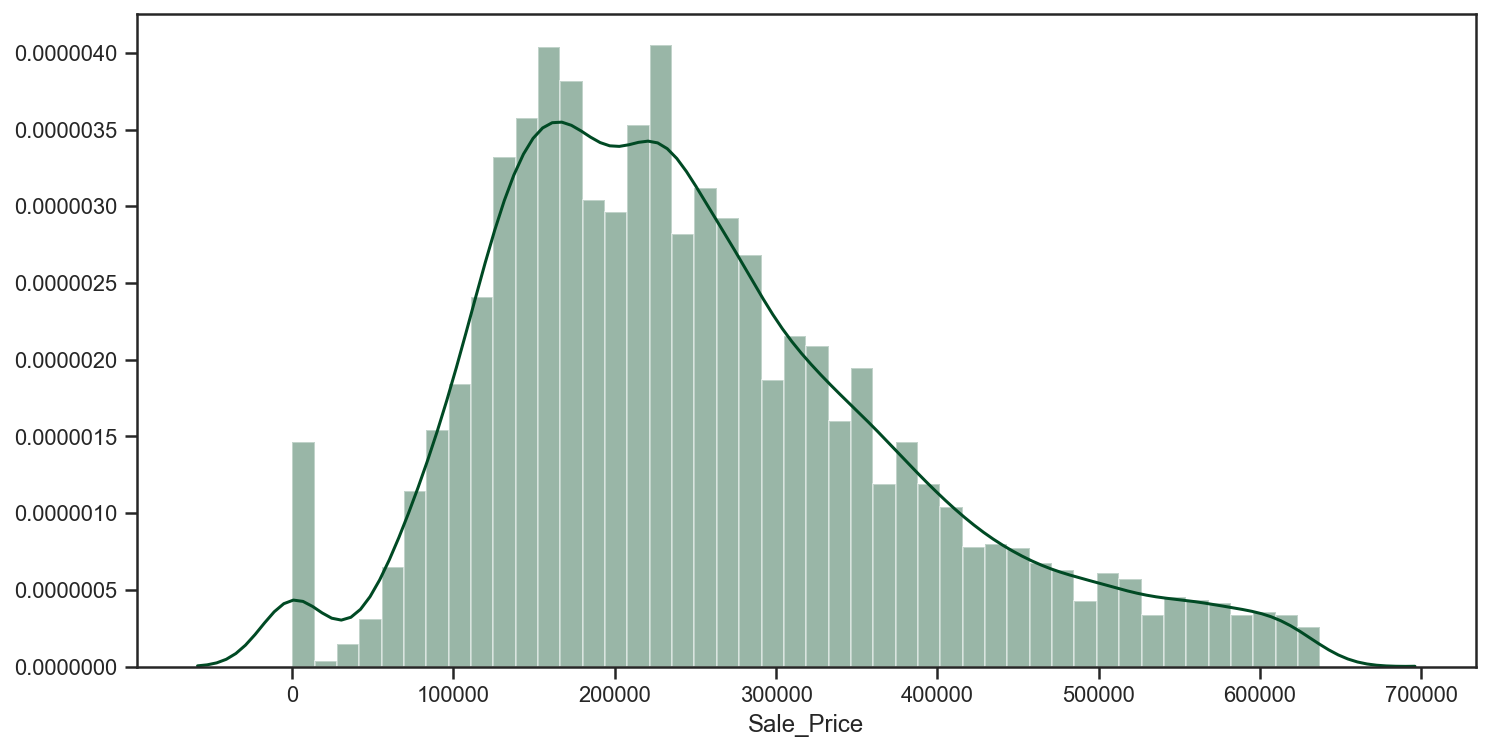

In [27]:
sns.distplot(clean_df3["Sale_Price"])

We still notice that there is a property with zero price; lets take a closer look

In [28]:
clean_df3[clean_df3["Sale_Price"]<1000]

PIN                      Property_Address  Tax_Year  \
90      8144010000000       606  DEMPSTER ST MOUNT PROSPECT      2018   
154    11191100000000                1100  OAK AVE EVANSTON      2018   
188     2171020000000            229  FLORENCE RD INVERNESS      2018   
326     7302080000000        989  YORKSHIRE DR HANOVER PARK      2018   
413    12011200000000           1648  NEWTON AVE PARK RIDGE      2018   
...               ...                                   ...       ...   
19422  10164000000000               9101  LAWLER AVE SKOKIE      2018   
19438  10193000000000                 8212 N NEVA AVE NILES      2018   
19589   2242120000000             111  PATRICIA LN PALATINE      2018   
19709   8133200000000          441  MARSHALL DR DES PLAINES      2018   
19839   8323200000000  1135  LEICESTER RD ELK GROVE VILLAGE      2018   

       Property_Class  Census_Tract Type_of_Residence  Rooms  Bedrooms  \
90                211      805002.0               2.0   15.0       9.0   
154               206      809800.0               2.0    8.0       4.0   
188               278      803603.0               2.0    9.0       4.0   
326               278      804805.0               2.0    8.0       4.0   
413               278      810400.0               2.0    8.0       4.0   
...               ...           ...               ...    ...       ...   
19422             211      807000.0               2.0   12.0       6.0   
19438             234      808200.0               4.0    7.0       4.0   
19589             278      803901.0               2.0    9.0       4.0   
19709             203      804902.0               1.0    5.0       3.0   
19839             204      770201.0               1.0    7.0       3.0   

      Basement  Fireplaces  ... Half_Baths  Building_Square_Feet  \
90         1.0         0.0  ...        3.0                3167.0   
154        1.0         1.0  ...        1.0                2812.0   
188        3.0         1.0  ...        1.0                2813.0   
326        2.0         0.0  ...        0.0                2672.0   
413        1.0         1.0  ...        1.0                3130.0   
...        ...         ...  ...        ...                   ...   
19422      1.0         0.0  ...        2.0                2787.0   
19438      3.0         0.0  ...        1.0                1564.0   
19589      4.0         0.0  ...        1.0                2180.0   
19709      3.0         0.0  ...        0.0                1548.0   
19839      2.0         1.0  ...        1.0                2080.0   

       Land_Square_Feet    Age  Longitude   Latitude  Walkscore  \
90               4540.0   43.0 -87.948745  42.037591       52.0   
154              5412.0  115.0 -87.686590  42.037776       80.0   
188             55321.0   29.0 -88.101340  42.121111        5.0   
326              8307.0   44.0 -88.133758  42.013145       27.0   
413              7643.0   16.0 -87.824610  41.989385       37.0   
...                 ...    ...        ...        ...        ...   
19422            6381.0   60.0 -87.752291  42.046615       62.0   
19438            7500.0   57.0 -87.804716  42.030323       60.0   
19589            8451.0   49.0 -88.006956  42.107932        7.0   
19709            6998.0   45.0 -87.931232  42.044091       52.0   
19839            8250.0    7.0 -88.013438  41.998567       44.0   

                 Walkfac  Sale_Price Total_Baths  
90     Somewhat Walkable           1         6.0  
154        Very Walkable           1         4.0  
188        Car-Dependent           1         3.0  
326        Car-Dependent           1         2.0  
413        Car-Dependent           1         4.0  
...                  ...         ...         ...  
19422  Somewhat Walkable           1         4.0  
19438  Somewhat Walkable           1         3.0  
19589      Car-Dependent           1         3.0  
19709  Somewhat Walkable           1         2.0  
19839      Car-Dependent           1         3.0  

[253 rows x 22 co

Seemingly, the issue is that there's c.a. 250 rows with a sale price of 1; it is unclear what these properties are. Maybe some sort of museums or protected properties. <br> Let us remove these properties, as having a US$1 assessment for a 'normal' household would throw our model off. <br> While we're at it, let us also remove the one single property with building squre feet <10 and few properties with 20+ rooms.

In [29]:
clean_df4 = clean_df3[(clean_df3["Sale_Price"]>1000) & (clean_df3["Building_Square_Feet"]>10) & (clean_df3["Rooms"]<20)]

In [30]:
clean_df4.describe()

PIN      Tax_Year  Property_Class   Census_Tract  \
count  1.228600e+04  12286.000000    12286.000000   12286.000000   
mean   1.604312e+13   2010.956943      220.321341  689861.052010   
std    8.012087e+12      5.914877       30.301278  234346.587798   
min    1.011000e+12   2003.000000      200.000000   10201.000000   
25%    1.014122e+13   2005.000000      203.000000  691300.000000   
50%    1.520103e+13   2010.000000      204.000000  805202.000000   
75%    2.035321e+13   2018.000000      234.000000  820202.000000   
max    3.331207e+13   2018.000000      297.000000  843900.000000   

              Rooms      Bedrooms    Fireplaces    Full_Baths    Half_Baths  \
count  12286.000000  12286.000000  12286.000000  12286.000000  12286.000000   
mean       6.414374      3.258343      0.284389      1.480303      0.439932   
std        1.959073      0.965418      0.513421      0.623821      0.528948   
min        2.000000      1.000000      0.000000      1.000000      0.000000   
25%        5.000000      3.000000      0.000000      1.000000      0.000000   
50%        6.000000      3.000000      0.000000      1.000000      0.000000   
75%        7.000000      4.000000      1.000000      2.000000      1.000000   
max       19.000000      9.000000      9.000000      5.000000      5.000000   

       Building_Square_Feet  Land_Square_Feet           Age     Longitude  \
count          12286.000000      12286.000000  12286.000000  12286.000000   
mean            1556.487465       6729.066580     59.529383    -87.806138   
std              614.748814       9160.514479     28.092447      0.155431   
min              400.000000        398.000000      1.000000    -88.249985   
25%             1103.000000       3750.000000     43.000000    -87.870032   
50%             1368.000000       5320.000000     56.000000    -87.777467   
75%             1885.750000       7980.000000     81.000000    -87.700774   
max             3715.000000     450890.000000    163.000000    -87.525559   

           Latitude     Walkscore     Sale_Price   Total_Baths  
count  12286.000000  12286.000000   12286.000000  12286.000000  
mean      41.866143     55.319958  255843.445304      1.920234  
std        0.169243     21.999584  124132.959990      0.826791  
min       41.470024      0.000000    5000.000000      1.000000  
25%       41.740632     40.000000  162000.000000      1.000000  
50%       41.894655     58.000000  231950.000000      2.000000  
75%       42.013823     73.000000  325000.000000      2.000000  
max       42.156899     99.000000  637500.000000      8.000000

A quick check using 'desribe' shows that the zero values have been removed from Sale Price and Building Square Feet

In [31]:
clean_df3.shape

(12545, 22)

In [32]:
clean_df4.shape

(12286, 22)

We remove c.a. 260 columns

Removing these US$1 properties doesn't take away a lot of the sample points; so I think it's OK to proceed. Let's try generating a revised correlation matrix

In [33]:
correlation3 = clean_df4.corr()

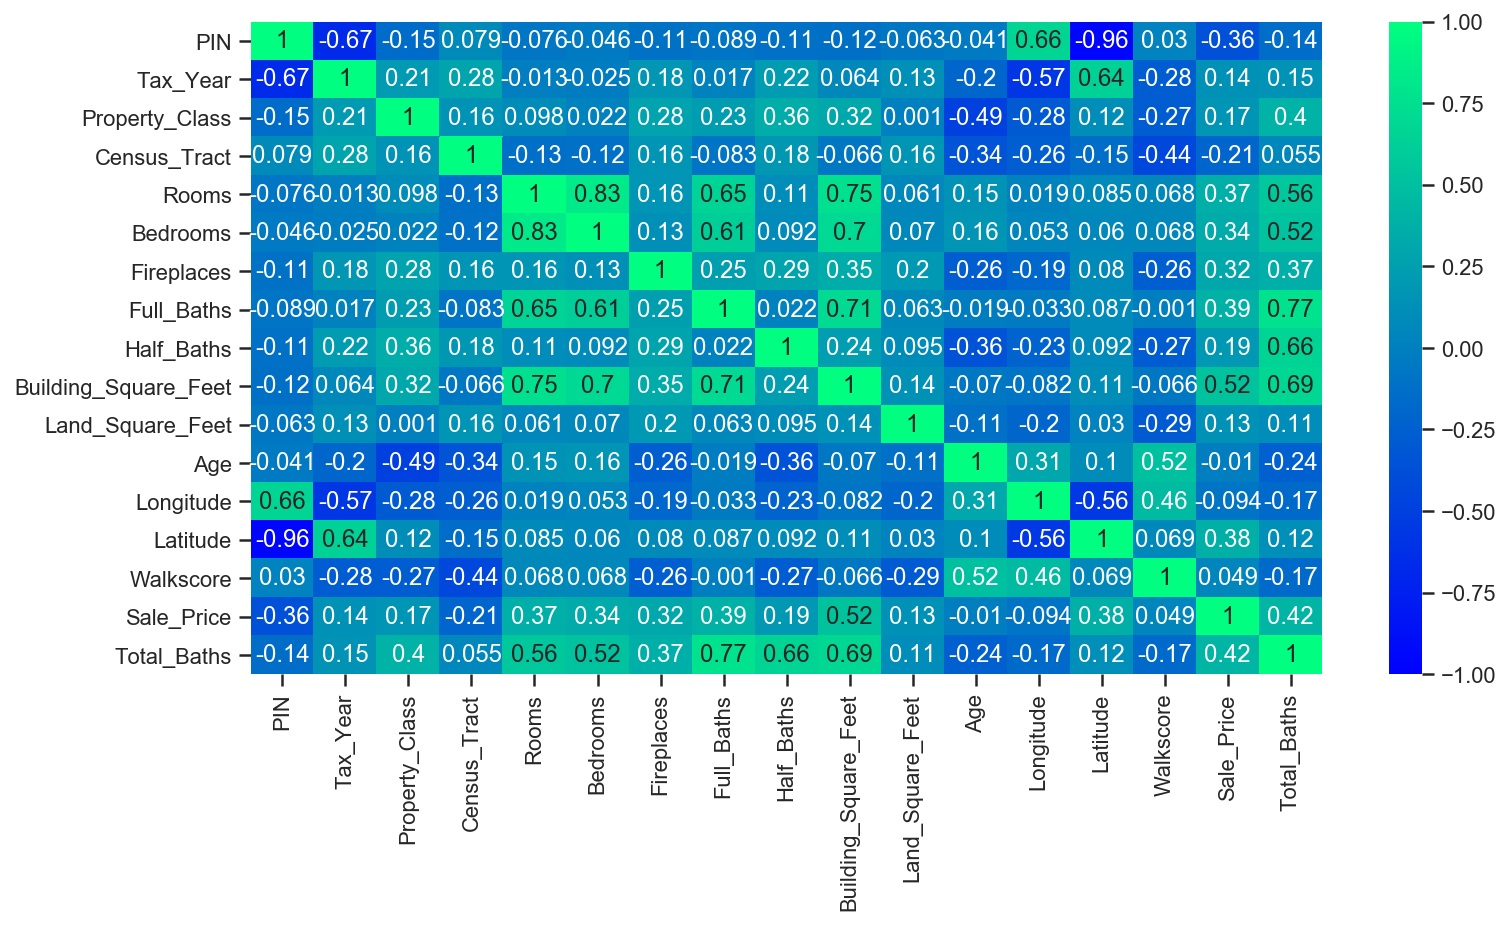

In [34]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation3, annot = True, cmap  = 'winter', vmax = 1, vmin = -1)

Let us add some lognormal columns at this stage

In [35]:
clean_df4["ln_Build_Square_Feet"]=np.log(clean_df4["Building_Square_Feet"])

/Users/prashant/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


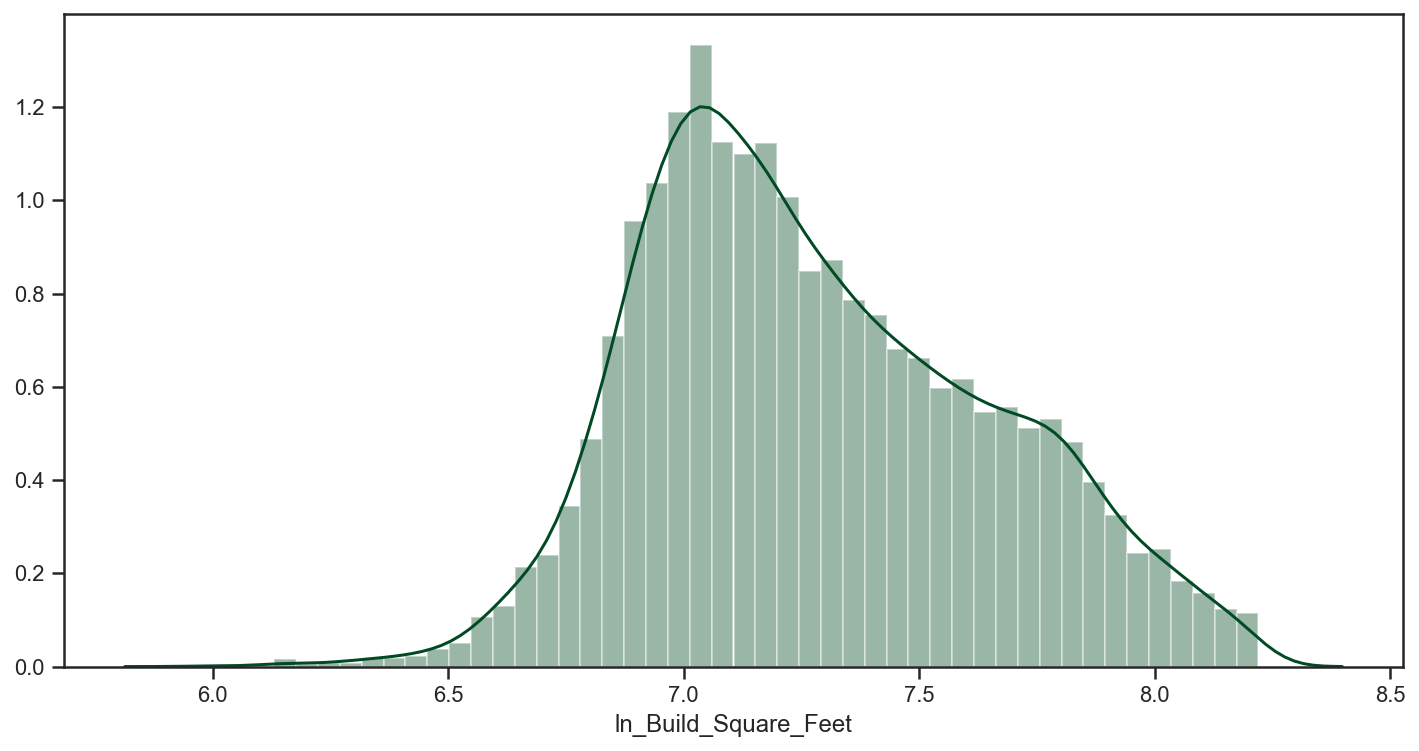

In [36]:
sns.distplot(clean_df4["ln_Build_Square_Feet"])

In [37]:
clean_df4["ln_Sale_Price"]=np.log(clean_df4["Sale_Price"])

/Users/prashant/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


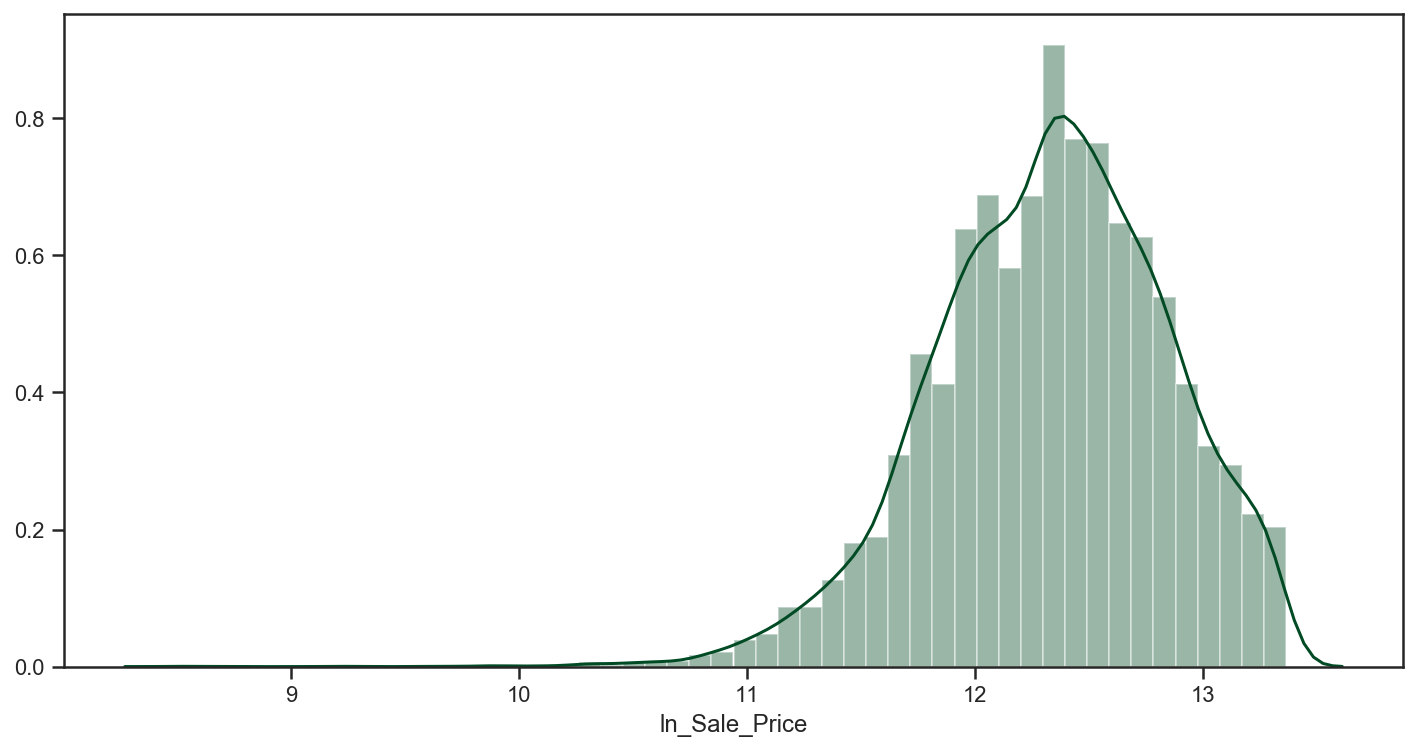

In [38]:
sns.distplot(clean_df4["ln_Sale_Price"])

Unclear as to whether or not the lognormal will help, but we'll evaluate that when we get to the OLS models.

Let us do a quick t-test to make sure that the two distributions still have the same means

In [148]:
from scipy.stats import ttest_ind
t2, p2 = scipy.stats.ttest_ind(clean_df4["Sale_Price"],clean_df4["Sale_Price"])
print("t = " + str(t2))
print("p = " + str(p2))

t = 0.0
p = 1.0


Since p>alpha (0.5) - we accept the null hypothesis that the means are similar.

Similar to before, we notice that: Rooms, Bedrooms, Full Baths, Half Baths, Building Squre Feet and total Baths have explanatory power. We'll investigate individual variables now.

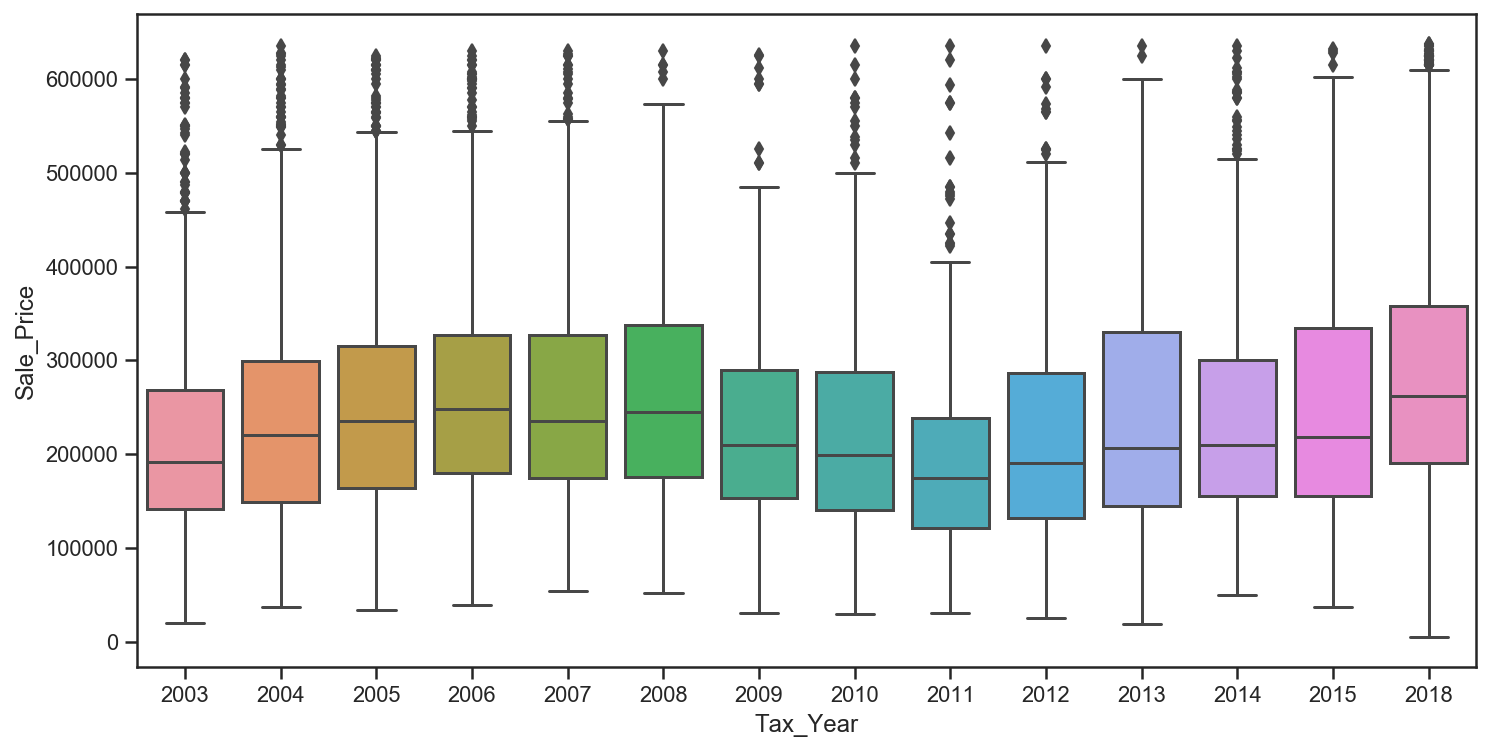

In [39]:
sns.boxplot(data=clean_df4,x="Tax_Year",y="Sale_Price")

Seemingly follows consumer inflation or some other macro metric. I would hypothesis that tax revenue is somewhat correlated to inflation here; but further investigation would be needed.

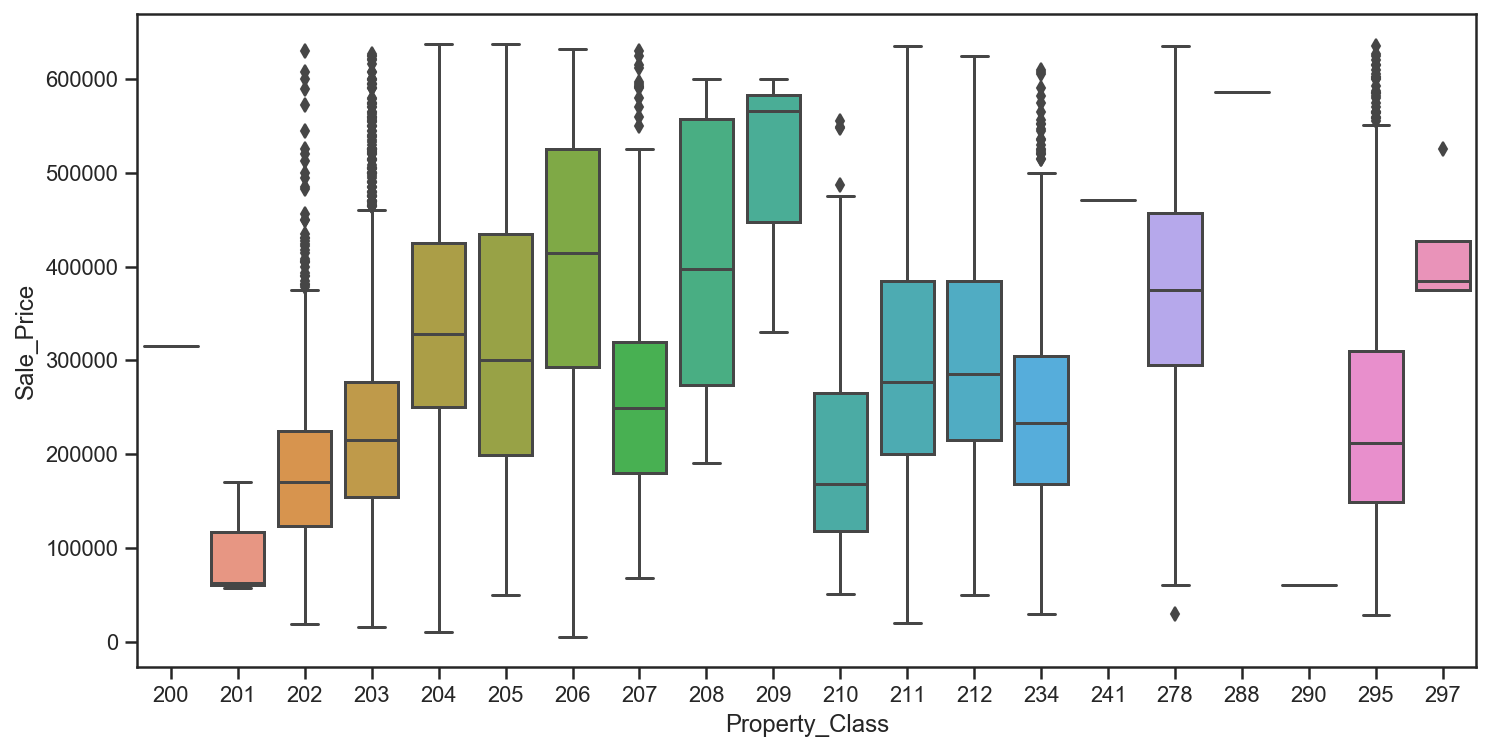

In [40]:
sns.boxplot(data=clean_df4,x="Property_Class",y="Sale_Price")

I would have expected the property classes to hold explanatory power, but it seems that it is not so obvious. There's a very wide range for all types of properties.

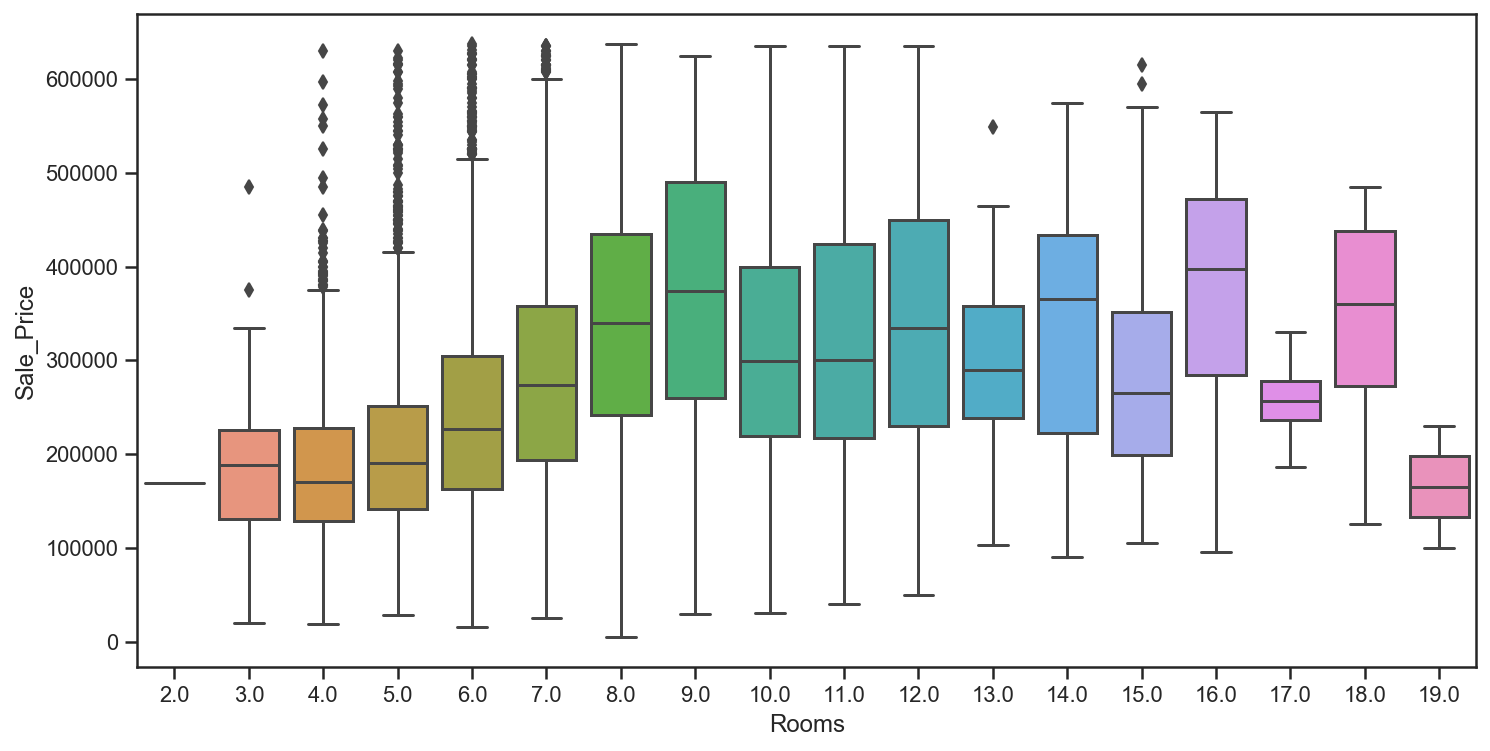

In [41]:
sns.boxplot(data=clean_df4,x="Rooms",y="Sale_Price")

Seemingly, more rooms add to the sales price upto nine rooms. After that, prices actually drop. Seems like something to do with property types. Further investigation by each property class would be needed.

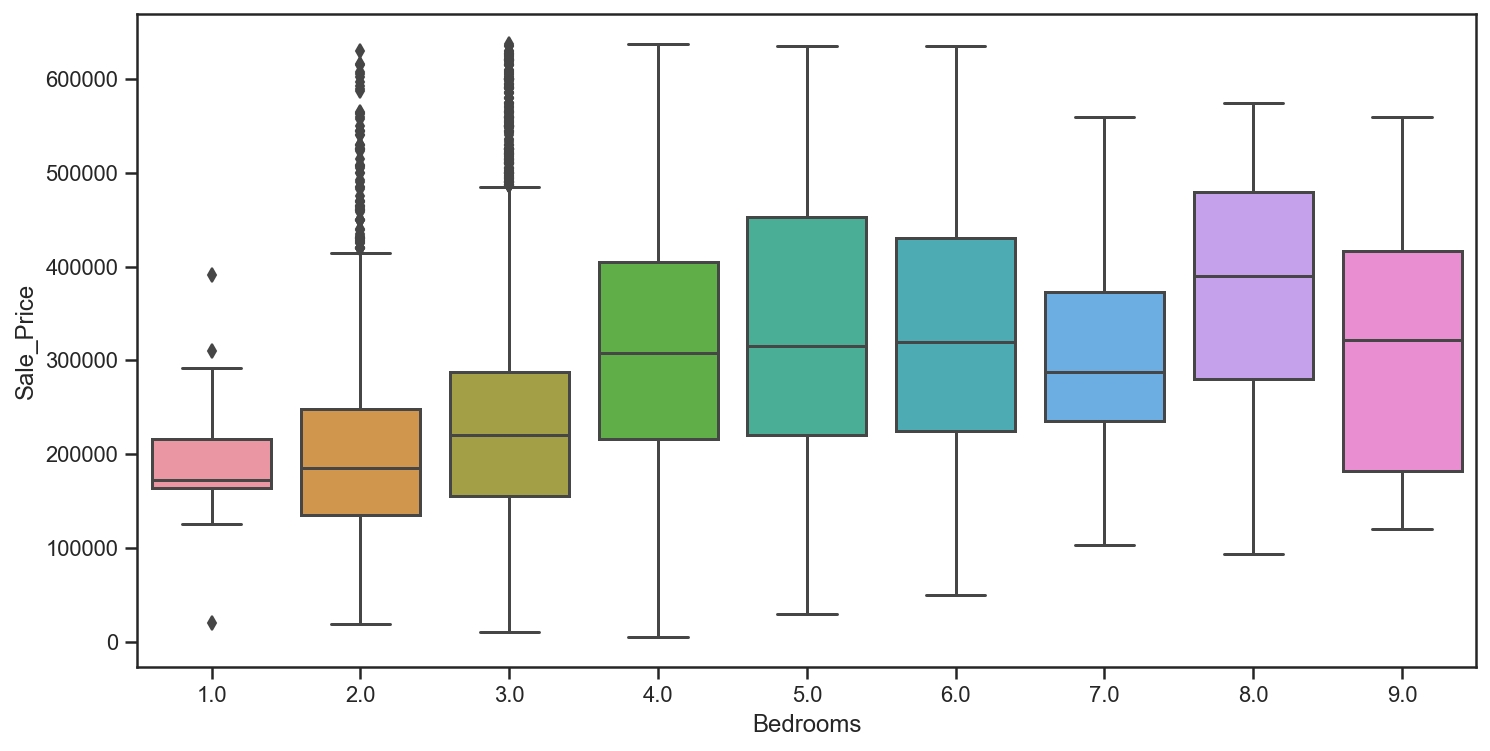

In [42]:
sns.boxplot(data=clean_df4,x="Bedrooms",y="Sale_Price")

Similar to rooms, property prices seem to be positively correlated to # of bedrooms upto four. Unclear after that.

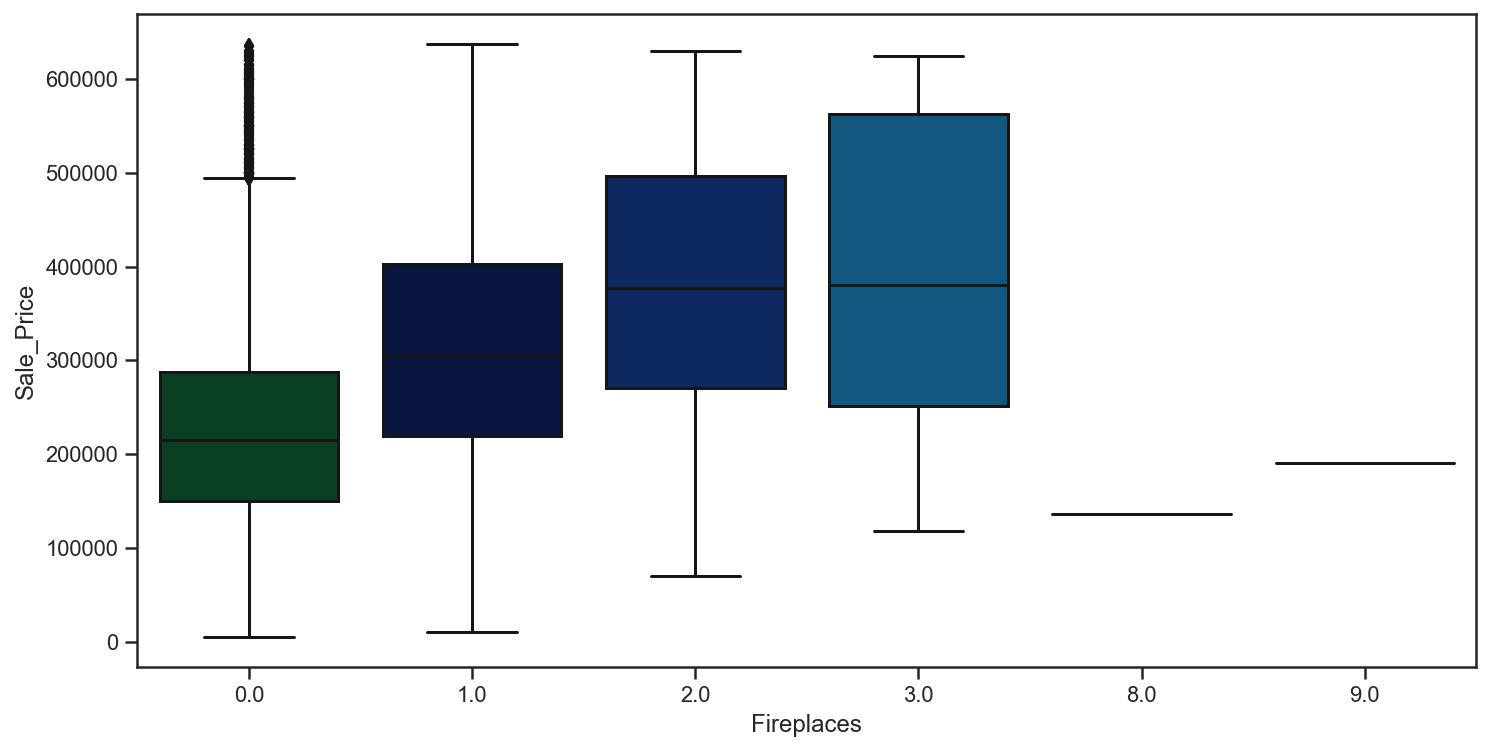

In [43]:
sns.boxplot(data=clean_df4,x="Fireplaces",y="Sale_Price")

It's not so obvious to me why adding more fireplaces would be good thing. There could be negative environmental consequences to this i.e. more fireplaces, more carbon emitted and more carbon tax.

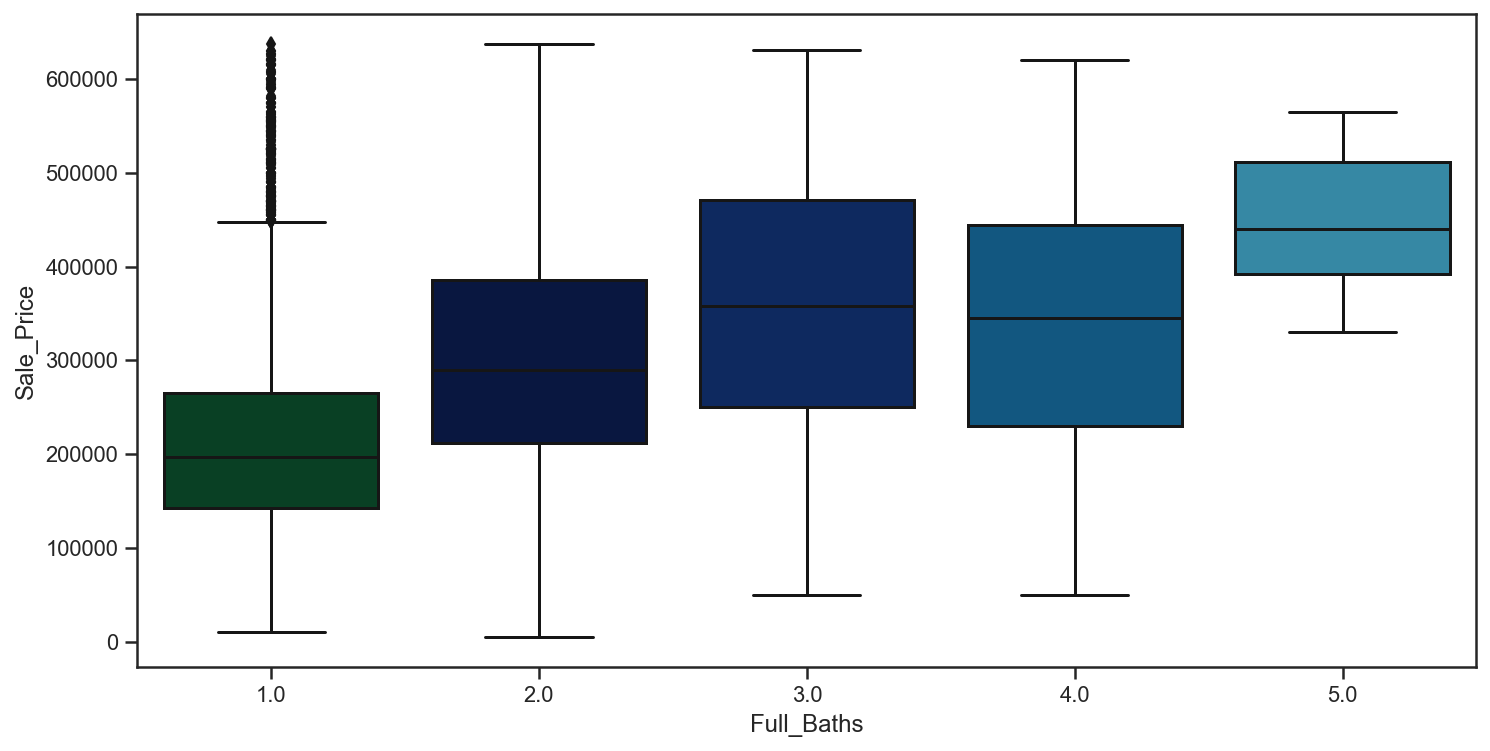

In [44]:
sns.boxplot(data=clean_df4,x="Full_Baths",y="Sale_Price")

Intuitively, adding more bathrooms boosts the property price. Let's try half-baths and total-baths below as well.

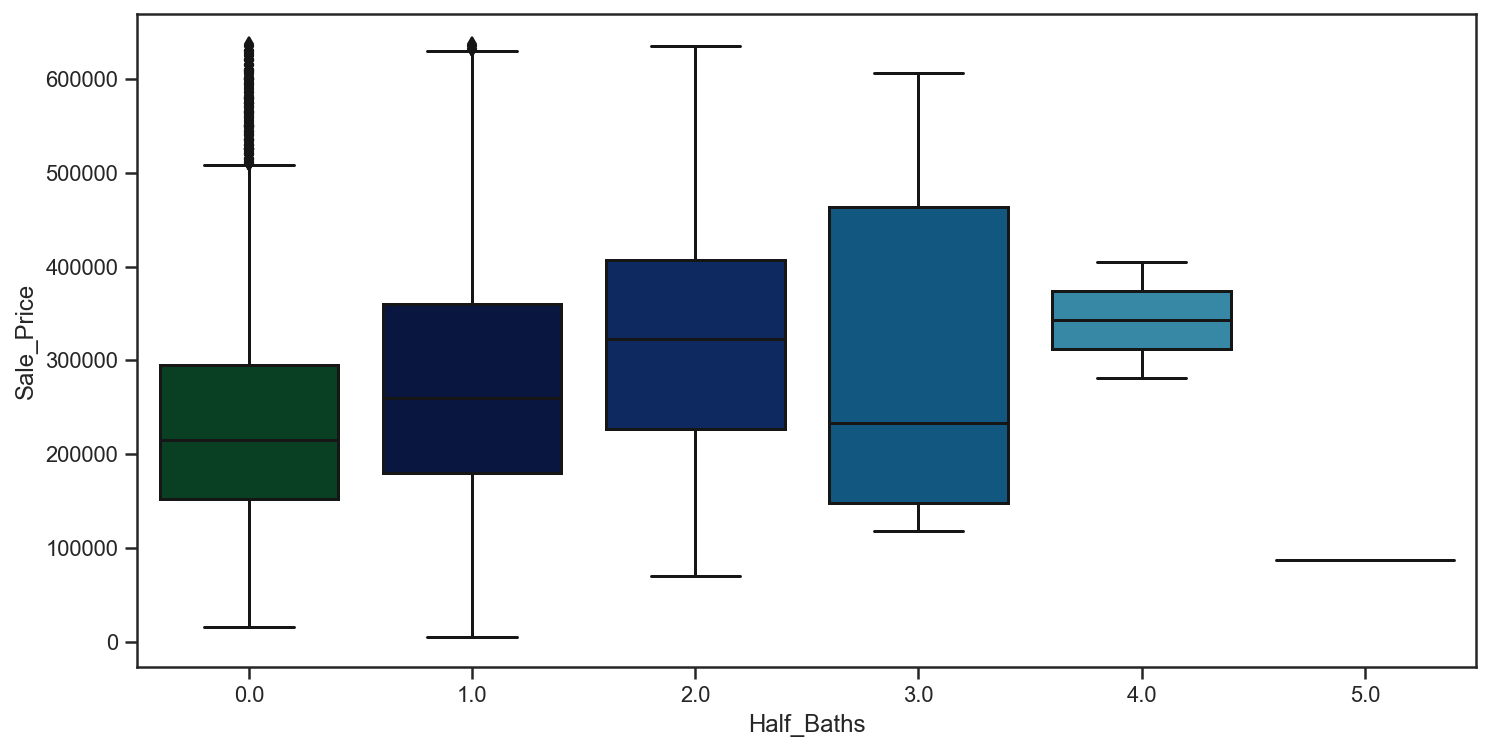

In [45]:
sns.boxplot(data=clean_df4,x="Half_Baths",y="Sale_Price")

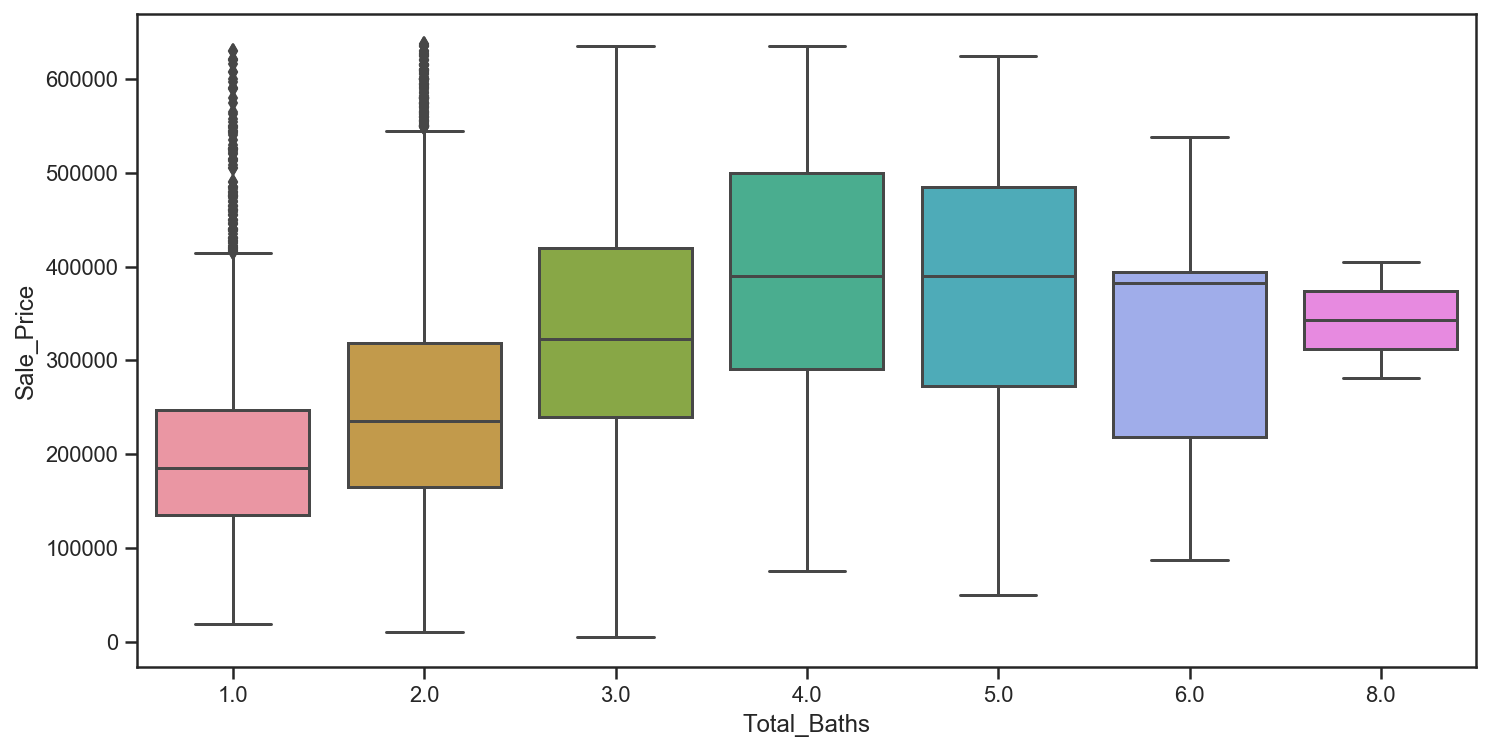

In [46]:
sns.boxplot(data=clean_df4,x="Total_Baths",y="Sale_Price")

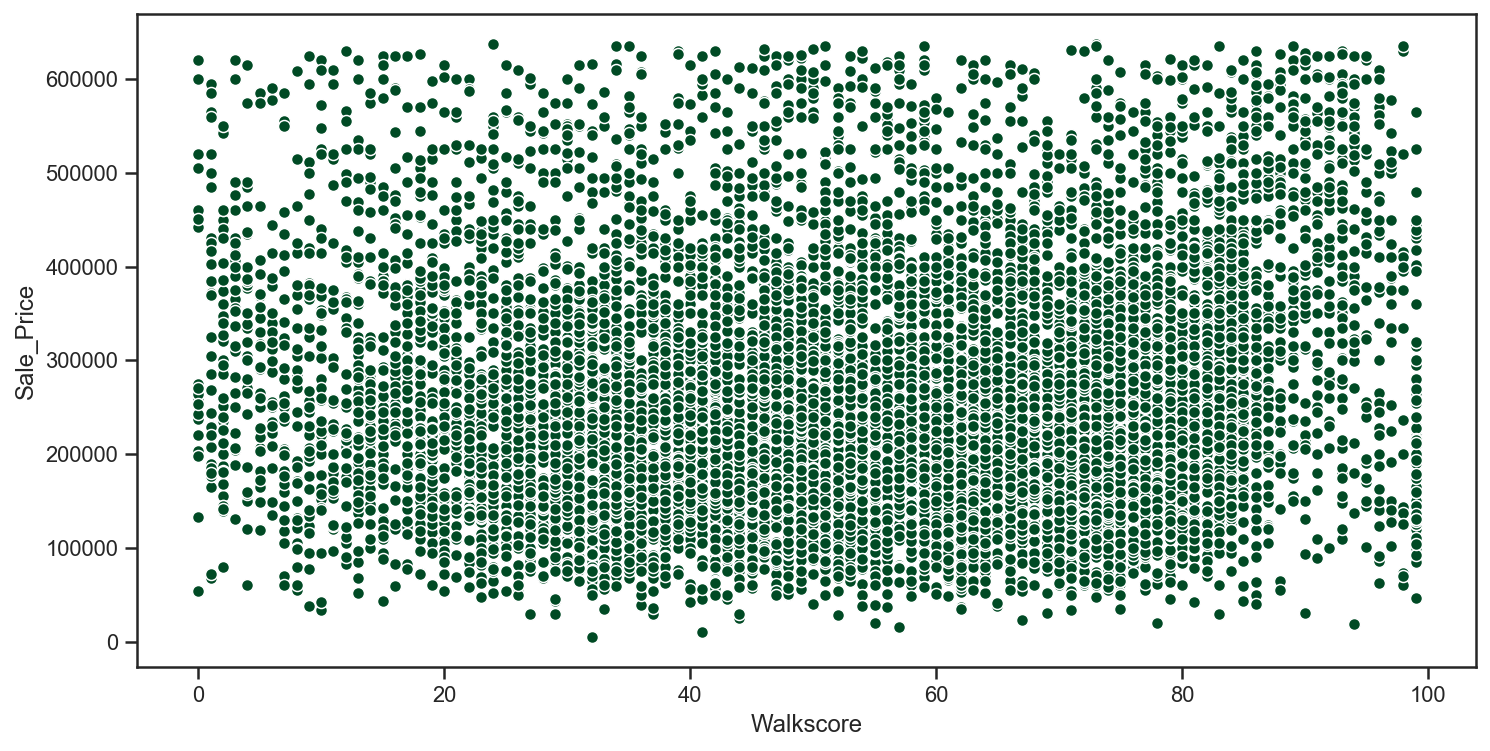

In [47]:
sns.scatterplot(data=clean_df4,x="Walkscore",y="Sale_Price")

Interestingly, walkscore is not correlated to Sale_Price. No obvious trend in the above chart, which means walkscore is an opinion of various people about many things.

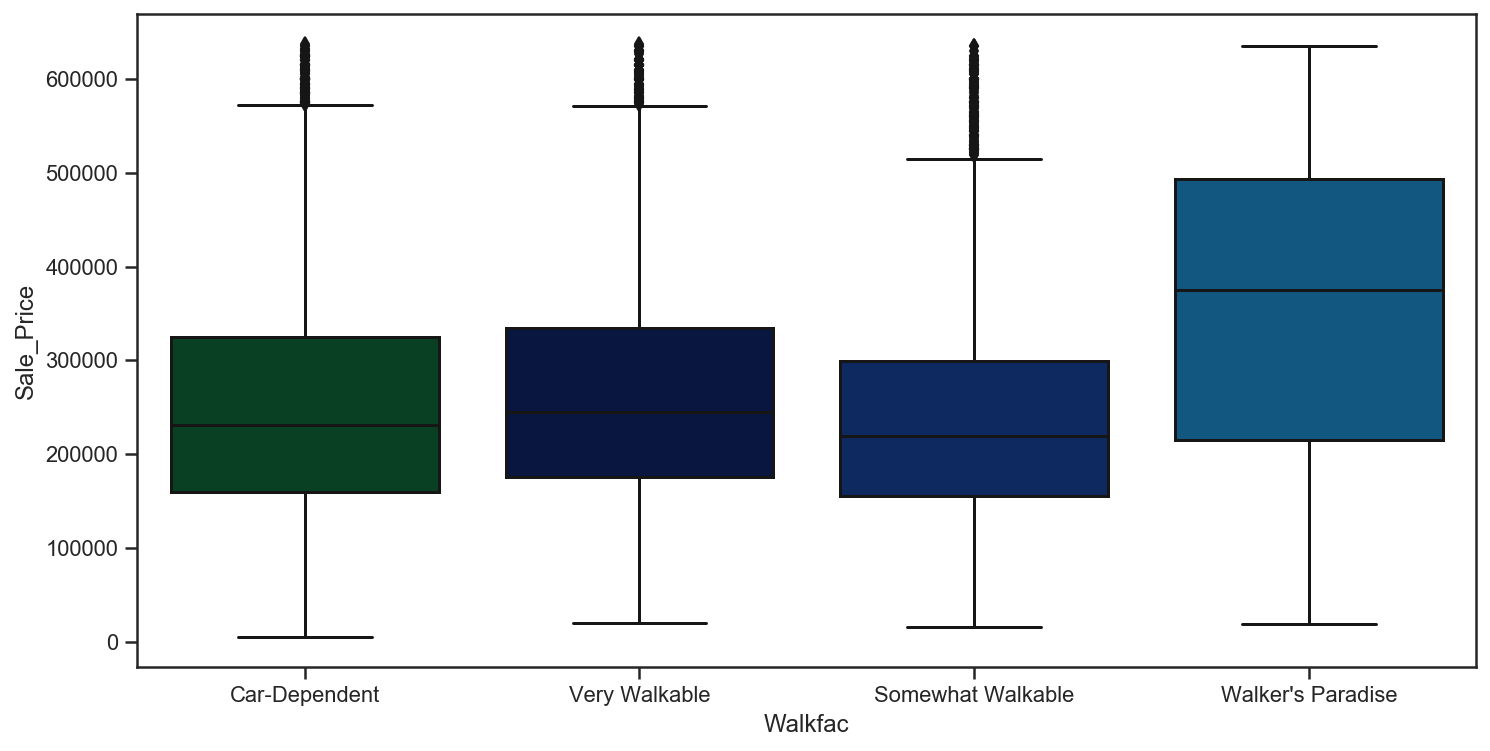

In [48]:
sns.boxplot(data=clean_df4,x="Walkfac",y="Sale_Price")

Only obvious thing we see in the above chart is that 'Walkers Paradise' labeled properties are much more expensive in some cases.

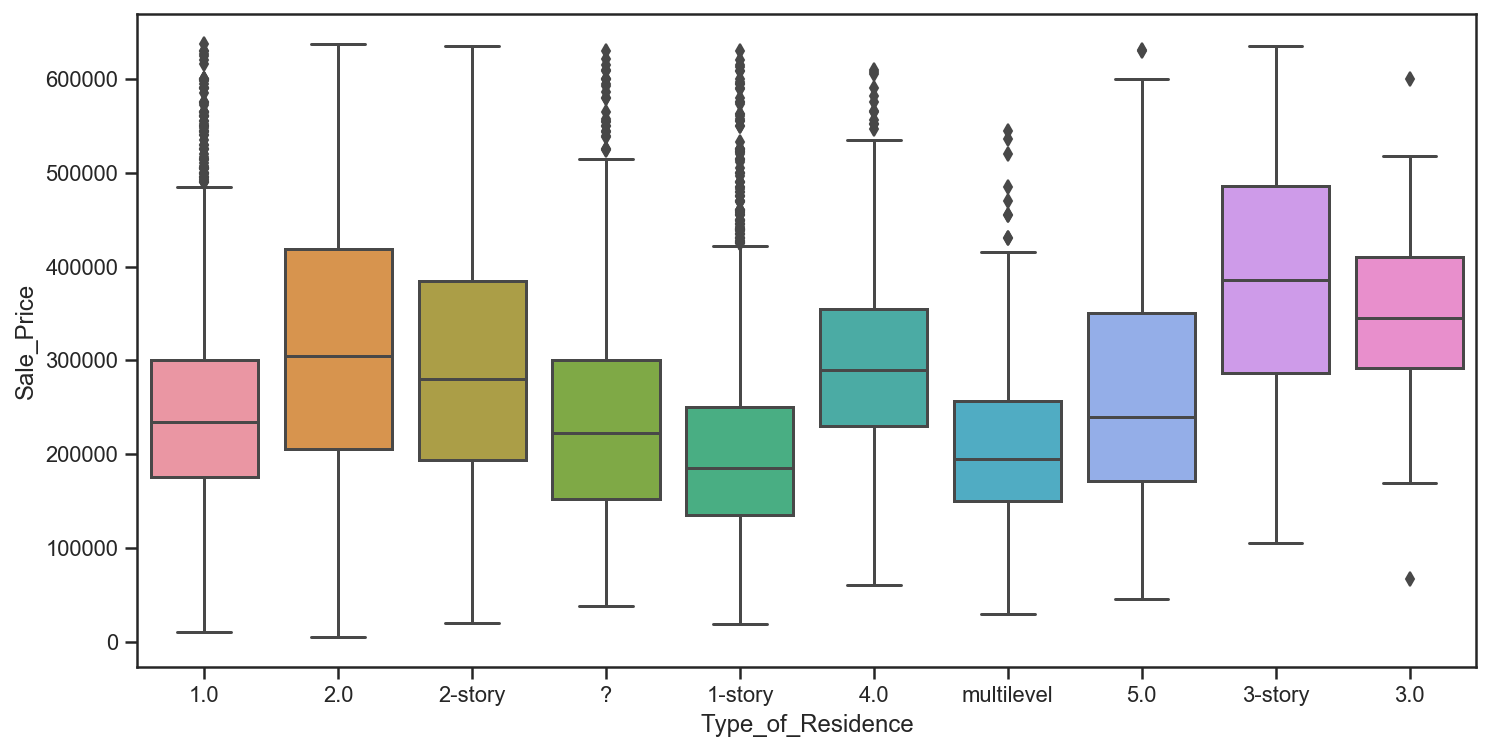

In [50]:
sns.boxplot(data=clean_df4,x="Type_of_Residence",y="Sale_Price")

There seems to be an issue with the encoding of this data set. Let's proceed for now; we can adjust the data values if this feature is needed for the model.

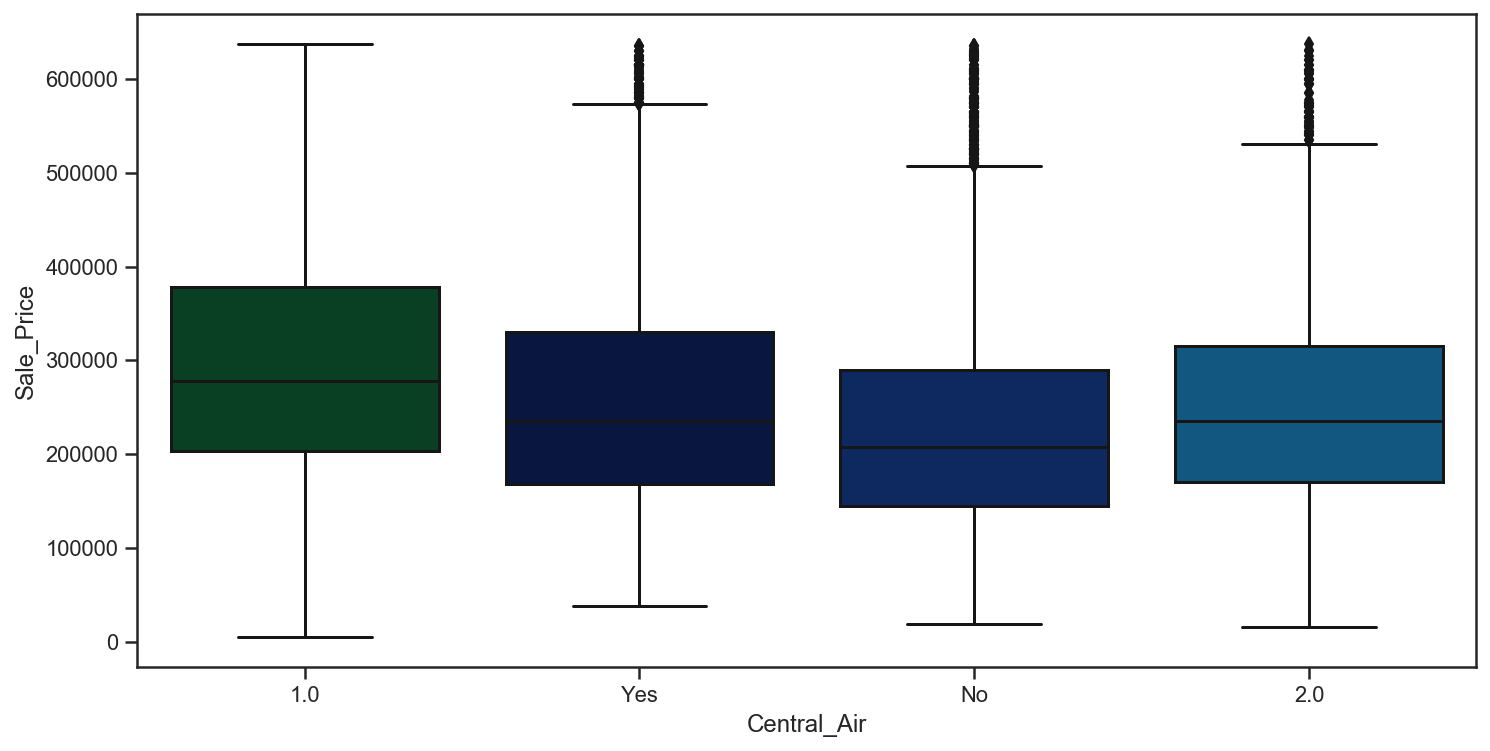

In [51]:
sns.boxplot(data=clean_df4,x="Central_Air",y="Sale_Price")

In [52]:
clean_df4["Central_Air"].unique()

array(['1.0', 'Yes', 'No', '2.0'], dtype=object)

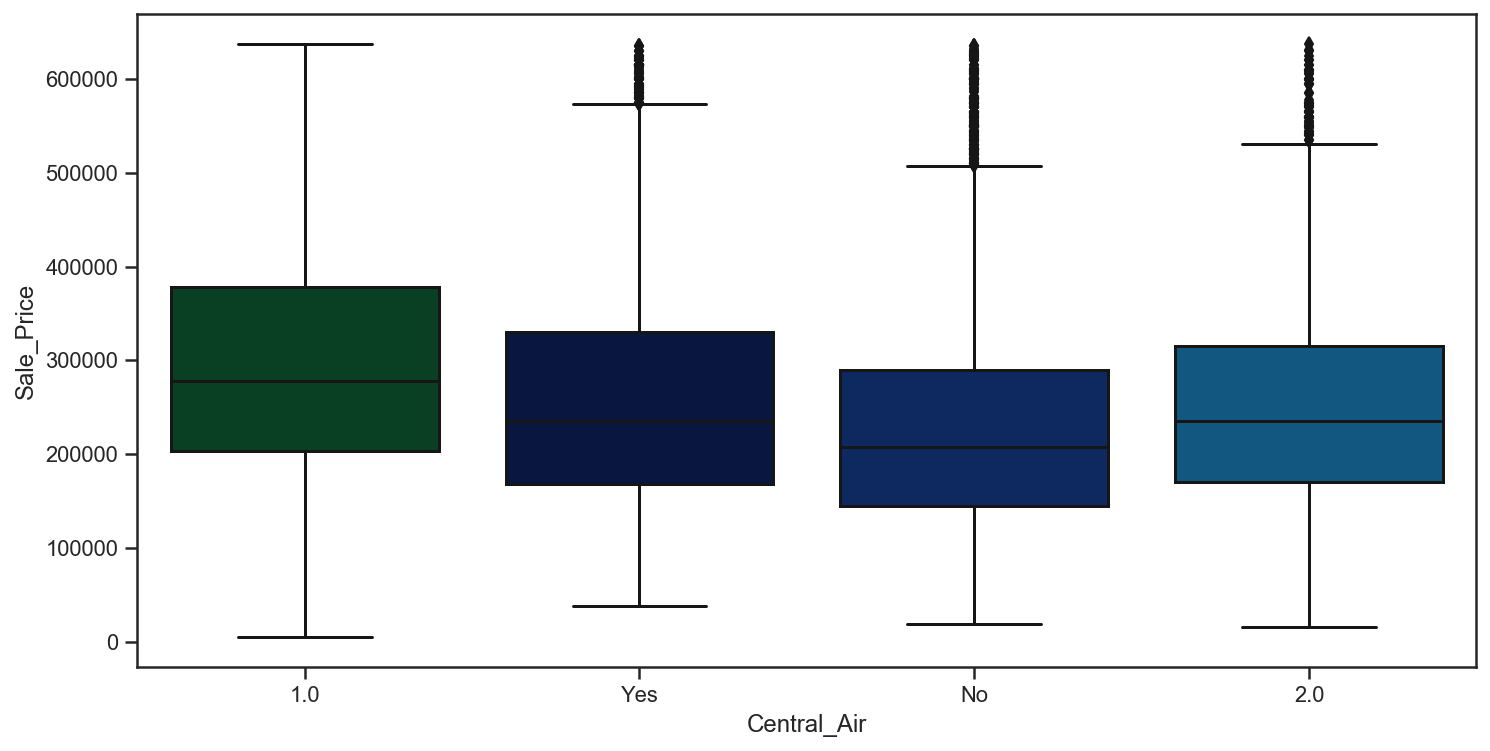

In [53]:
sns.boxplot(data=clean_df4,x="Central_Air",y="Sale_Price")

Seems like there is an encoding issues; we'll have to fix this issue before including central air as a feature.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


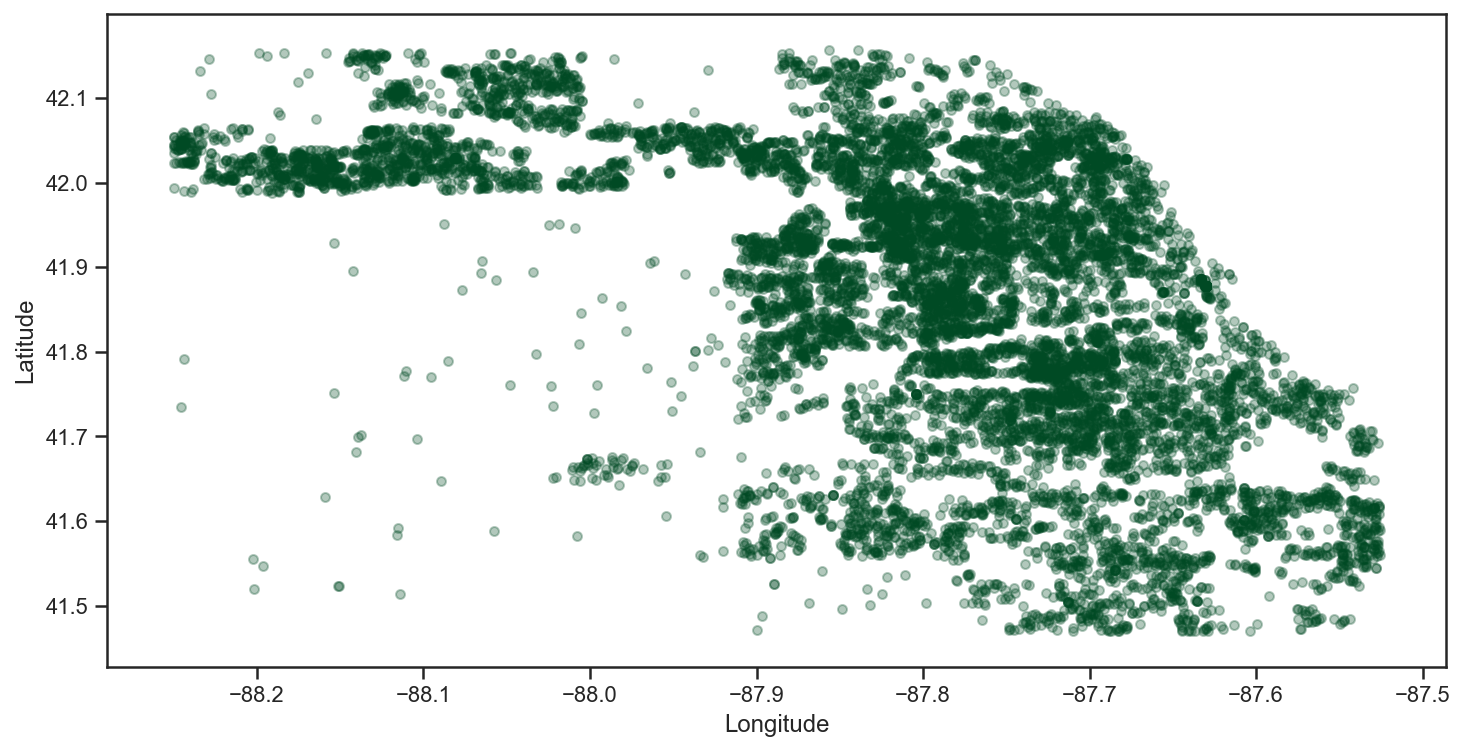

In [92]:
import matplotlib.pyplot as plt
clean_df4.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.3)
sns.despine(ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

I'm not familiar with the Chicago area and as such, I can not comment on what's a good neighborhood and a bad neighborhood. Including such biases are not good for modeling in any cases. Geo-encoding analysis is out of scope for now, but there could be some interesting conclusions that could be drawn from the lat/long dat.

### Feature selection, modeling and optimisation 

Let's try a model with some features that I hypothesized previously. I'll exclude central air for now. I'll use a standard OLS model using sales price, building square feet, total baths, bedrooms and property class. 

In [55]:
formula = 'Sale_Price ~ Building_Square_Feet + Fireplaces + Total_Baths + Bedrooms + Property_Class  - 1'
linear_areas_only = smf.ols(formula=formula, data=clean_df4).fit()
linear_areas_only.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Sale_Price   R-squared (uncentered):                   0.863
Model:                            OLS   Adj. R-squared (uncentered):              0.863
Method:                 Least Squares   F-statistic:                          1.553e+04
Date:                Sat, 31 Oct 2020   Prob (F-statistic):                        0.00
Time:                        17:23:15   Log-Likelihood:                     -1.5949e+05
No. Observations:               12286   AIC:                                  3.190e+05
Df Residuals:                   12281   BIC:                                  3.190e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Building_Square_Feet    84.0677      2.619     32.101      0.000      78.934      89.201
Fireplaces            3.107e+04   2046.483     15.181      0.000    2.71e+04    3.51e+04
Total_Baths           9491.9479   1656.545      5.730      0.000    6244.860    1.27e+04
Bedrooms              5910.0506   1271.238      4.649      0.000    3418.224    8401.877
Property_Class         348.3328     14.799     23.538      0.000     319.325     377.341
==============================================================================
Omnibus:                      713.303   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              912.802
Skew:                           0.561   Prob(JB):                    6.13e-199
Kurtosis:                       3.724   Cond. No.                     3.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Although the model fit is good, the standard errors are large. I've discussed previously that log-normal distributions could be used to improve results, as taking a ln somewhat removes the skew. 

Let's try an alternative model with ln:

In [123]:
formula2 = 'ln_Sale_Price ~ ln_Build_Square_Feet + Fireplaces + Total_Baths + Bedrooms + Property_Class  - 1'
linear_areas_only2 = smf.ols(formula=formula2, data=clean_df4).fit()
linear_areas_only2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          ln_Sale_Price   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.432e+06
Date:                Sun, 01 Nov 2020   Prob (F-statistic):                        0.00
Time:                        13:13:44   Log-Likelihood:                         -9178.5
No. Observations:               12286   AIC:                                  1.837e+04
Df Residuals:                   12281   BIC:                                  1.840e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
ln_Build_Square_Feet     1.8491      0.006    290.709      0.000       1.837       1.862
Fireplaces              -0.0279      0.010     -2.873      0.004      -0.047      -0.009
Total_Baths             -0.1486      0.007    -20.087      0.000      -0.163      -0.134
Bedrooms                -0.2260      0.006    -35.368      0.000      -0.239      -0.213
Property_Class          -0.0005      0.000     -2.835      0.005      -0.001      -0.000
==============================================================================
Omnibus:                      627.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1320.590
Skew:                          -0.352   Prob(JB):                    1.73e-287
Kurtosis:                       4.444   Cond. No.                         501.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model results are good at this stage just looking at the R-squred. However, the model still has a skew of -0.35. <br>
Ideally, there would be no skew. <br>
The condition # (measures the sensitivity of a function's output as compared to its input) is still very high. Let's try one more model to improve our results.

Let's fix the encoding issue with Central_Air first.

In [57]:
clean_df4.dtypes

PIN                       int64
Property_Address         object
Tax_Year                  int64
Property_Class            int64
Census_Tract            float64
Type_of_Residence        object
Rooms                   float64
Bedrooms                float64
Basement                 object
Fireplaces              float64
Central_Air              object
Full_Baths              float64
Half_Baths              float64
Building_Square_Feet    float64
Land_Square_Feet        float64
Age                     float64
Longitude               float64
Latitude                float64
Walkscore               float64
Walkfac                  object
Sale_Price                int64
Total_Baths             float64
ln_Build_Square_Feet    float64
ln_Sale_Price           float64
dtype: object

In [58]:
clean_df5=clean_df4

Let's replace "Yes" with "1" and "No" with "2".

In [59]:
clean_df5['Central_Air'] = clean_df5.Central_Air.str.replace('Yes', '1')

/Users/prashant/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
clean_df5['Central_Air'] = clean_df5.Central_Air.str.replace('No', '2')

/Users/prashant/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
clean_df5.dtypes

PIN                       int64
Property_Address         object
Tax_Year                  int64
Property_Class            int64
Census_Tract            float64
Type_of_Residence        object
Rooms                   float64
Bedrooms                float64
Basement                 object
Fireplaces              float64
Central_Air             float64
Full_Baths              float64
Half_Baths              float64
Building_Square_Feet    float64
Land_Square_Feet        float64
Age                     float64
Longitude               float64
Latitude                float64
Walkscore               float64
Walkfac                  object
Sale_Price                int64
Total_Baths             float64
ln_Build_Square_Feet    float64
ln_Sale_Price           float64
dtype: object

In [62]:
clean_df5['Central_Air'] = clean_df5.Central_Air.astype(float)

/Users/prashant/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Central_Air should be encoded as a float now.

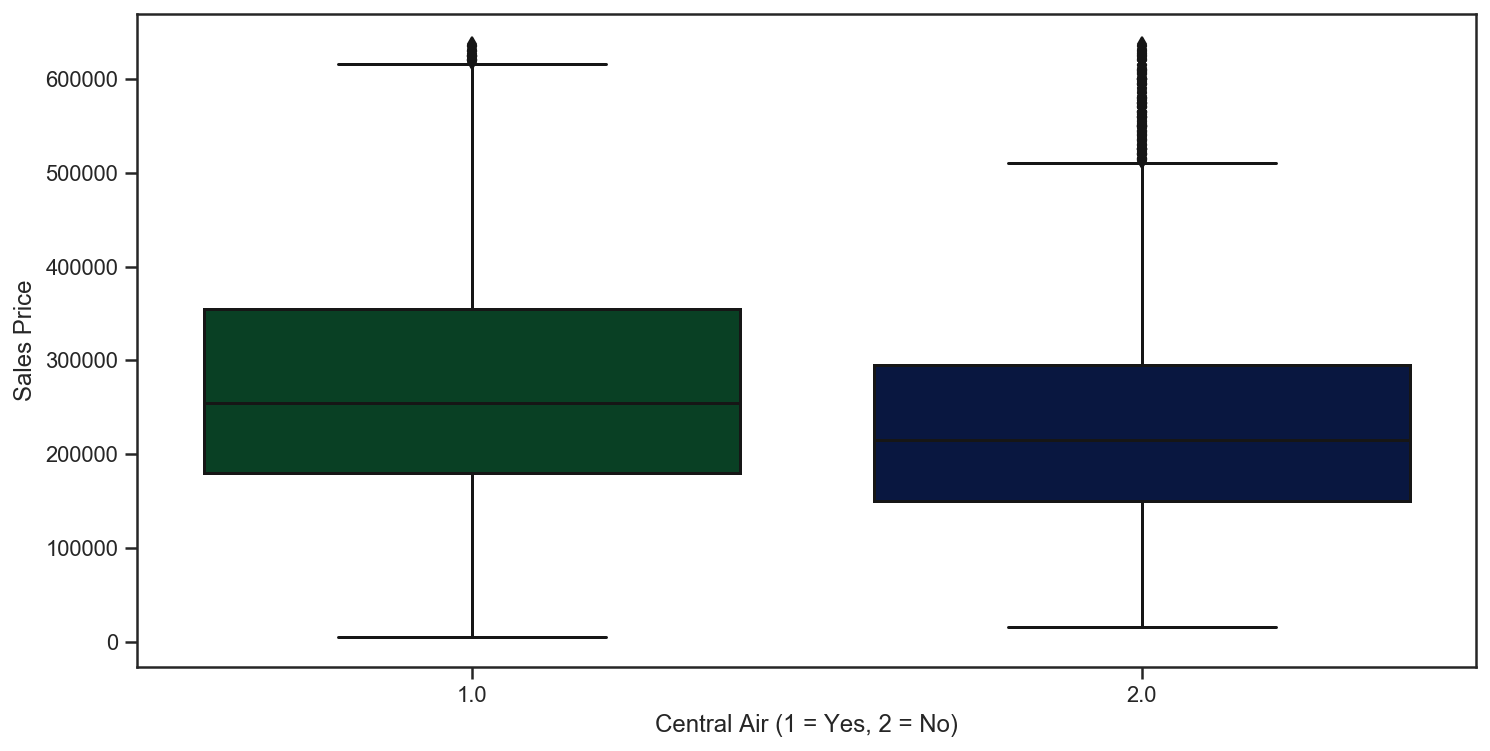

In [110]:
ax3 = sns.boxplot(data=clean_df5,x="Central_Air",y="Sale_Price")
ax3.set(ylabel='Sales Price', xlabel='Central Air (1 = Yes, 2 = No)')
plt.show()

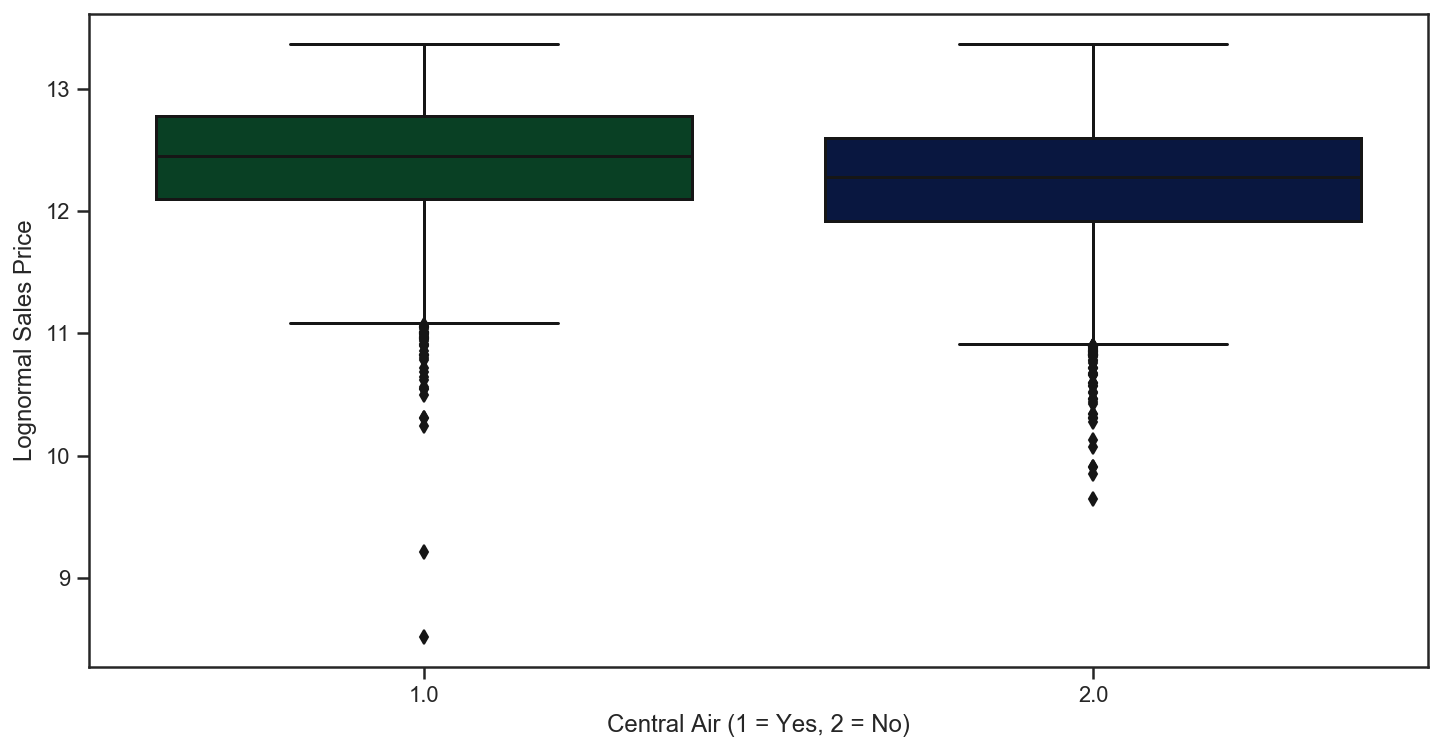

In [111]:
ax4 = sns.boxplot(data=clean_df5,x="Central_Air",y="ln_Sale_Price")
ax4.set(ylabel='Lognormal Sales Price', xlabel='Central Air (1 = Yes, 2 = No)')
plt.show()

Although having 'Central_Air' does mean a higher price, it's not a very big difference. I would have thought that it would have made a much bigger impact.

Let's try another model with Central Air now.

In [149]:
formula3 = 'ln_Sale_Price ~ ln_Build_Square_Feet + Total_Baths + Bedrooms + Central_Air - 1'
linear_areas_only3 = smf.ols(formula=formula3, data=clean_df5).fit()
linear_areas_only3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          ln_Sale_Price   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.796e+06
Date:                Sun, 01 Nov 2020   Prob (F-statistic):                        0.00
Time:                        18:12:17   Log-Likelihood:                         -9157.8
No. Observations:               12286   AIC:                                  1.832e+04
Df Residuals:                   12282   BIC:                                  1.835e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
ln_Build_Square_Feet     1.8141      0.004    512.110      0.000       1.807       1.821
Total_Baths             -0.1392      0.007    -19.135      0.000      -0.153      -0.125
Bedrooms                -0.2247      0.006    -37.674      0.000      -0.236      -0.213
Central_Air              0.0748      0.010      7.682      0.000       0.056       0.094
==============================================================================
Omnibus:                      628.253   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1253.014
Skew:                          -0.369   Prob(JB):                    8.15e-273
Kurtosis:                       4.380   Cond. No.                         19.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model selection, optimization and interpretation

Our results are very good at this stage just looking at the r-squared. We notice that the condition No. is less than 30. The model still has a skew, so there's further investigation needed into some of the parameters. The Durbin-Watson # should be between 1 and 2. Ideally the # would be lower, however, this is sufficient for now.  

In [173]:
clean_df5.head(3)

PIN                Property_Address  Tax_Year  Property_Class  \
0   8124170000000  613 S SCHOOL ST MOUNT PROSPECT      2018             203   
2   6352050000000        602  MAPLE DR STREAMWOOD      2018             278   
3  27174070330000                   10626 DANI LN      2014             295   

   Census_Tract Type_of_Residence  Rooms  Bedrooms          Basement  \
0      804901.0               1.0    6.0       4.0               1.0   
2      804509.0               2.0    8.0       4.0               3.0   
3      824114.0           2-story    5.0       3.0  Partial basement   

   Fireplaces  ...  Land_Square_Feet   Age  Longitude   Latitude  Walkscore  \
0         1.0  ...            8712.0  60.0 -87.930691  42.054184       49.0   
2         0.0  ...            8316.0  19.0 -88.168322  42.002096       15.0   
3         1.0  ...            1399.0   7.0 -87.878278  41.604719       29.0   

         Walkfac  Sale_Price  Total_Baths  ln_Build_Square_Feet ln_Sale_Price  
0  Car-Dependent      298000          2.0              7.286876     12.604849  
2  Car-Dependent      255000          3.0              7.707063     12.449019  
3  Car-Dependent      254900          3.0              7.504942     12.448627  

[3 rows x 24 columns]

Let's use the 2nd row as a test case and flow that through our model now:

In [174]:
clean_df5.head(3)["Central_Air"]

0    1.0
2    1.0
3    1.0
Name: Central_Air, dtype: float64

In [175]:
test_sale_price = 1.8141*(7.707063) -0.1392*(3) -0.2247*(4) +0.0748*1

In [176]:
test_sale_price

12.7397829883

Note that the test_sale_price should be compared to the value in the final column in the above table i.e. 12.449

Let's interpret the coefficients of the model quickly. Notice that I don't have a constant factor in my chosen model i.e. there is no Beta0. <br>

The ln_building_sq_feet metric reads as - for each ln('1 meter') addition to the meter sq. value, add 1.81 to the ln(final price).

<br>
Similarly, each bathroom will reduce our model output value by 0.1392, and each bedroom will reduce our model output by 0.2247. 
<br>

Having central air (i.e. value of Yes =1) adds roughly 0.0748 to the ln(final price).

### Hypothesis testing and validation

Let's make another check on the model quality by looking at the residuals.

Linearity and quality variance test:

In [129]:
pred_val = linear_areas_only3.fittedvalues.copy()
true_val = clean_df5['Sale_Price'].values.copy()
residual = true_val - pred_val

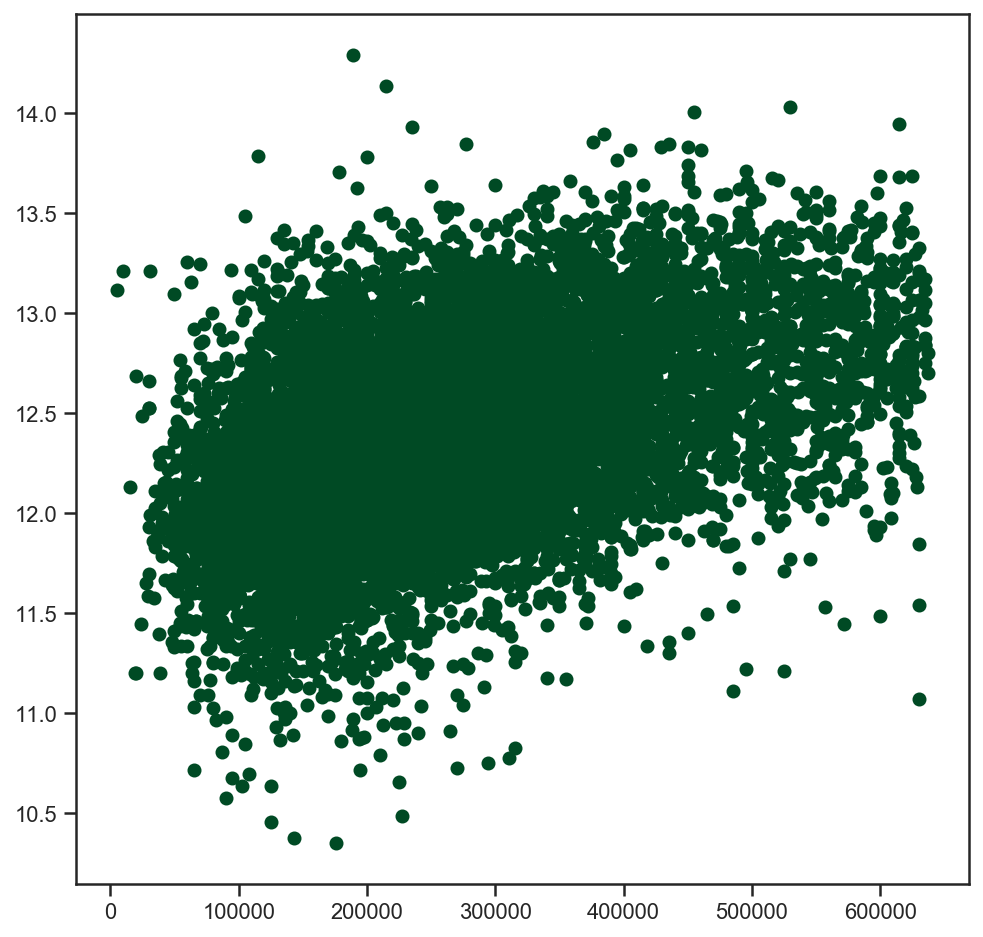

In [130]:
fig, ax5 = plt.subplots(figsize=(8,8))
_ = ax5.scatter(residual, pred_val)

Normality test (visual):

0.9457110676772663

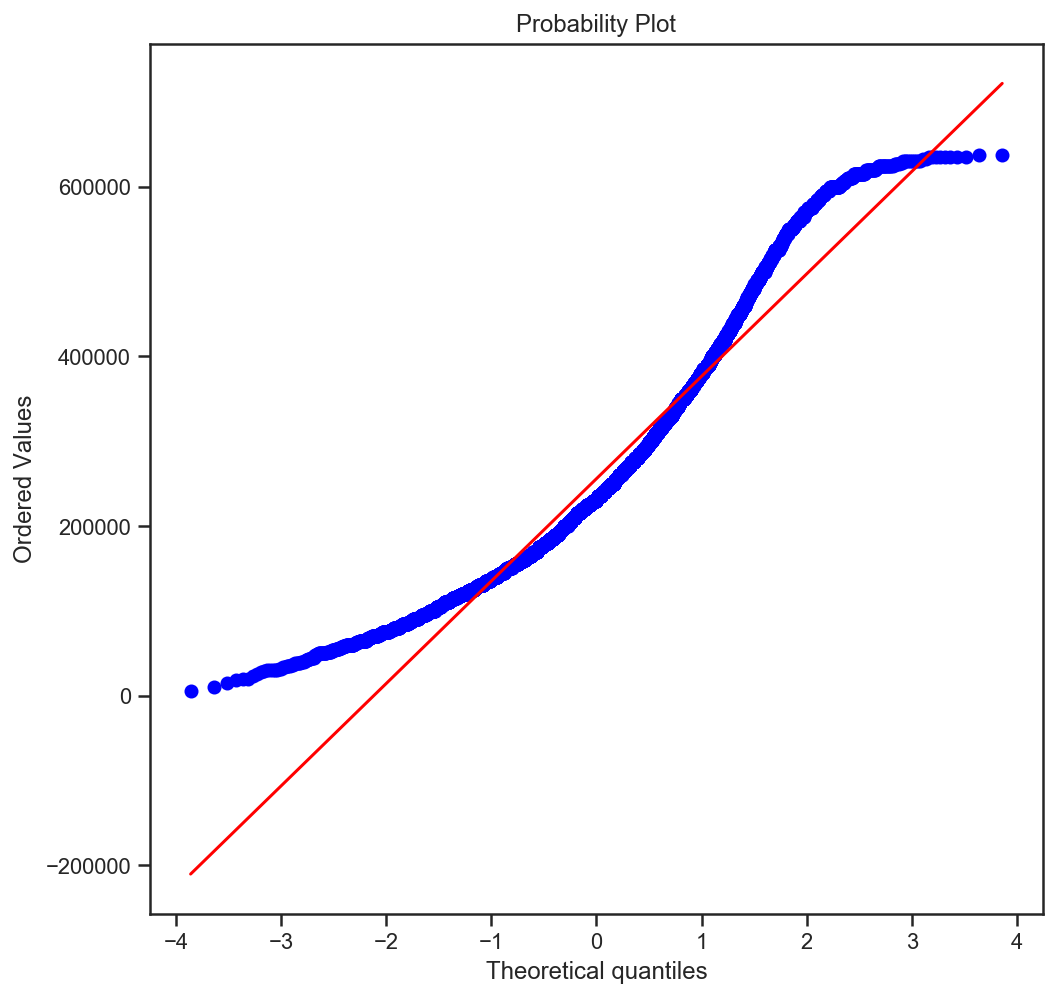

In [132]:
import scipy as scipy
fig, ax6 = plt.subplots(figsize=(8,8))
_, (__, ___, r) = scipy.stats.probplot(residual, plot=ax6, fit=True)
r**2

The linearity and quality viariance test shows that the residuals are mostly randomly distributed. Although there is a slight bias as the residuals move upwards with higher values. <br>

We applied the normal probability plot to assess how the data (error) depart from normality visually. Seems that the results are mostly OK, except for near-zero or really high values. But a 95% R-squared gives us comform that the model is good for use.

Although our model results are already very good (99% R-squared factor), we perform one chi-squared test to very whether or not walkfac is connected to central_air.

In [84]:
crosstab_df = pd.crosstab(clean_df5['Central_Air'], clean_df5['Walkfac'])

In [85]:
crosstab_df

Walkfac      Car-Dependent  Somewhat Walkable  Very Walkable  \
Central_Air                                                    
1.0                   2972               1693            896   
2.0                   1749               2155           2422   

Walkfac      Walker's Paradise  
Central_Air                     
1.0                        111  
2.0                        288

In [90]:
from scipy import stats
stats.chi2_contingency(crosstab_df)

(1086.8068301047597,
 2.6503955414156355e-235,
 3,
 array([[2179.51424385, 1776.48184926, 1531.80009767,  184.20380921],
        [2541.48575615, 2071.51815074, 1786.19990233,  214.79619079]]))

The first value (1086.8) is the Chi-square value, followed by the p-value (2.65e-235), then comes the degrees of freedom (3), and lastly it outputs the expected frequencies as an array.<br> Since all of the expected frequencies are greater than 5, the chi2 test results can be trusted. We can reject the null hypothesis as the p-value is less than 0.05. <br>Thus, the results indicate that there is a relationship between walkfac and central. <br> Although I can't grasp my head around why this is the case, the data suggests so.

Note that we previously did a t-test on the ln_sale_price. Since p>alpha, we accepted the null hypothesis that means are similar  for the log-normal dist. of sale prices, and sale prices. As such, it is OK to use the ln_Sale price metric for our analysis. 

### Conclusion 

In conclusion, we have a well working model with a very high R-squared value (formula3). This tells us that, although there are dozens of parameters to work with, only a few hold bulk of the explanatory power. 

One could argue that some of the other parameters should be included anyways for ethical reasons or fairness reasons. 

We didn't account for long/lat and block-level data in our model. Maybe some of the skewness and residual error performance could be improved in a more advanced version of the study.

Now we are ready to proceed and figure out what these sales prices mean for taxes paid. 

### Checklist - rubrik vs delivery

To make sure I've delivered on the rubrik: <br>

Executive Summary - Done; stated at top <br>

Introduction (Motivation) - Done; stated at top <br>

Dataset Description - Done; I've commented on the shape of the data set throughout the pre-processing stages i.e. after removing NAs, after removing outliers, and some extreme cases (80 rooms) <br>

Data Cleaning - Done; I only performed one type conversion (Central Air), which was not really needed after all. I removed NA values and outliers. Removing outliers isn't always obvious, but I checked the values and saw that values were encoded with US$1 prices. Those values are clearly not correct <br>

Exploratory Data Analysis - Done; I generated several box/scatter plots to gain an understanding of all the key metrics provided. Legend is not interesting; so didn't include it.
<br> 

Correlation Analysis and Hypothesis Testing - Done; I generated a correlation matrix, and provided an interpretation. I highlighted the metrics with (seemingly) strong explanatory model. 
I used two tests - chi-squared test at the end and t-test while making a transformation. 

<br>
Feature Selection, Engineering, and Preprocessing - Done; I made only one numercial transformation (Central_Air) for my final model. I played around with a few combinations of features for the OLS model, but show-cased only the ones that made sense. 

Modeling and optimization - Done; I tried a few combinations, but the last model I've shown (with Central_Air) provides the best results. 

Conclusion - Done
